#Начало 1 часть

## Импорт необходимых модулей, обработка данных, поиск архитектур

In [ ]:
!pip install dlib


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from scipy.spatial import distance as dist
from imutils.video import VideoStream, FPS
from imutils import face_utils
from google.colab import files, drive

import imutils
import time
import dlib
import cv2
import zipfile
import io
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import dlib
import sys


drive.mount('/content/drive')
!cp /content/drive/My\ Drive/Colab\ Notebooks/Курс\ нейросетей/Курсовая/dataset.zip './'
!cp /content/drive/My\ Drive/Colab\ Notebooks/Курс\ нейросетей/Курсовая/shape_predictor_68_face_landmarks.zip './'

z = zipfile.ZipFile('dataset.zip', 'r')
z.extractall()
z = z = zipfile.ZipFile('shape_predictor_68_face_landmarks.zip', 'r')
z.extractall()




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Загрузка данных первого датасета

In [ ]:
f = h5py.File('train_happy.h5', 'r')
x_train = np.array(f['train_set_x'].value)
y_train = np.array(f['train_set_y'].value)

ft = h5py.File('test_happy.h5', 'r')
x_test= np.array(ft['test_set_x'].value)
y_test = np.array(ft['test_set_y'].value)
print("Тренировочный набор :", x_train.shape,y_train.shape)
print("Тестовый набор :", x_test.shape,y_test.shape)

Тренировочный набор : (600, 64, 64, 3) (600,)
Тестовый набор : (150, 64, 64, 3) (150,)


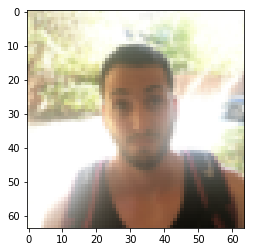

(64, 64)


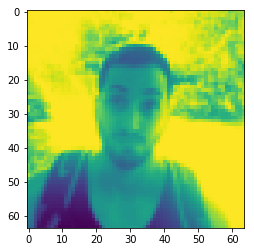

In [ ]:
x_train = np.array(f['train_set_x'].value)
y_train = np.array(f['train_set_y'].value)

i = 8
plt.imshow(x_train[i])
plt.show()
#print(y_train[i])




test_image = x_train[i][:,:,0]/255
print(test_image.shape)
#test_image_gray = cv2.cvtColor(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), cv2.COLOR_RGB2GRAY)

plt.imshow(test_image,)
plt.imshow(test_image[:, ::-1])

### Функция для аугментации данных 

In [ ]:
def augmet_dataset(x_train, y_train):
    x_inv_train = []
    y_inv_train = []
    for i in range(x_train.shape[0]):
        img = x_train[i]
        x_inv_train.append(img[:, ::-1])
        y_inv_train.append(y_train[i])
    x_inv_train = np.asarray(x_inv_train)
    y_inv_train = np.asarray(y_inv_train)
    x_inv_train = np.concatenate((x_train, x_inv_train), axis=0)
    y_inv_train = np.concatenate((y_train, y_inv_train), axis=0)
    return x_inv_train, y_inv_train

x_train, y_train = augmet_dataset(x_train, y_train)
print(x_train.shape, y_train.shape)

(1200, 64, 64, 3) (1200,)


### Преобразование данных.

Так как как во втором dataset данные представлены  в одномерном массиве, то  преобразуем 1 dataset в такой же формат данных. 

Произведен аугментацию данных для получения лучшего результата на текущей сети 

In [ ]:
def convertdataset(x_train):
    x_train1 = []
    for i in range(x_train.shape[0]):
        x_train1.append(np.expand_dims(x_train[i][:,:,0]/255,axis=2))
    x_train1 = np.asarray(x_train1)    
    print(x_train1.shape)
    return x_train1
x_train_dataset =  convertdataset(x_train)


(1200, 64, 64, 1)


### Определение нейронной сети и функций обратного вызова

Работа с нейросетью будем использовать три функции callback: LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

#### Поиск оптимального варианта сети и анализ результатов

In [ ]:
import random

layer1 = [10,15,20,25,30]
layer2 = [40,80,120,140,160]
layer3 = [100,160,220,300,460]
kernel1 = [5,7,9,11,15,20]
kernel2 = [5,7,9,11,15,20]
maxpolsize1 = [2,3,5,6]
maxpolsize2 = [2,3,5,6]
denslayer1 = [10,40,60,100,120]
denslayer2 = [5,10,20,30]

list_of_parametr = {'layer1':layer1,
                    'kernel1':kernel1,
                    'maxpolsize1':maxpolsize1,
                    'layer2':layer2,
                    'kernel2':kernel2,
                    'maxpolsize2':maxpolsize2,
                    'layer3':layer3,
                    'denslayer1':denslayer1,
                    'denslayer2':denslayer2}

def rand_param(list_of_param):
    x = random.randint(0,len(list_of_param)-1)
    #print(len(list_of_param))
    #print(x)
    return list_of_param[x]

    
def create_rnd_model():
    
    cod_of_models = []
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64, 64, 1)))
    
    number_neurons1 = rand_param(list_of_parametr['layer1'])
    size_of_cern = rand_param(list_of_parametr['kernel1'])
    maxpoll_size = rand_param(list_of_parametr['maxpolsize1'])
    
    cod_of_models.append(number_neurons1)
    cod_of_models.append(size_of_cern)
    cod_of_models.append(maxpoll_size)
    
    model.add(Conv2D(number_neurons1,kernel_size=(size_of_cern,size_of_cern),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(maxpoll_size, maxpoll_size)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    number_neurons2 = rand_param(list_of_parametr['layer2'])
    size_of_cern2 = rand_param(list_of_parametr['kernel2'])
    maxpoll_size2 = rand_param(list_of_parametr['maxpolsize2'])
    
    cod_of_models.append(number_neurons2)
    cod_of_models.append(size_of_cern2)
    cod_of_models.append(maxpoll_size2)
    
    model.add(Conv2D(number_neurons2,kernel_size=(size_of_cern2,size_of_cern2),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(maxpoll_size2,maxpoll_size2)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    if random.random() > 0.51:
        number_neurons3 = rand_param(list_of_parametr['layer2'])
        model.add(Conv2D(number_neurons3,kernel_size=(3,3), 
                         padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())
        
        cod_of_models.append(number_neurons3)
    else:
        cod_of_models.append(0)
    
    model.add(Flatten())

    numbers_denslayer1 = rand_param(list_of_parametr['denslayer1'])
    cod_of_models.append(numbers_denslayer1)
    
    model.add(Dense(numbers_denslayer1, activation='relu'))
    model.add(Dropout(0.1))
    
    if random.random() > 0.51:
        numbers_denslayer2 = rand_param(list_of_parametr['denslayer2'])
        model.add(Dense(numbers_denslayer2, activation='relu'))
        model.add(Dropout(0.1))
        cod_of_models.append(numbers_denslayer2)
    else:
        cod_of_models.append(0)
        
    
    model.add(Dense(1, activation='sigmoid'))
    cod_of_models.append(1)        
        
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    #print(model.summary())
    return model,cod_of_models

list_of_models = []
list_of_DNA = []
for i in range(30):
    model,cod_of_models = create_rnd_model()
    list_of_models.append(model)        
    list_of_DNA.append(cod_of_models)
print(list_of_DNA)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[[20, 7, 3, 120, 11, 5, 0, 40, 10, 1], [10, 20, 2, 140, 5, 2, 0, 40, 5, 1], [20, 15, 5, 80, 9, 6, 40, 10, 0, 1], [25, 7, 2, 80, 7, 3, 0, 40, 0, 1], [25, 15, 2, 80, 11, 6, 140, 40, 30, 1], [30, 11, 3, 160, 11, 3, 0, 100, 30, 1], [15, 7, 5, 80, 20, 5, 0, 10, 0, 1], [25, 15, 6, 120, 9, 2, 80, 100, 5, 1], [20, 7, 2, 160, 20, 3, 0, 10, 0, 1], [25, 9, 3, 80, 9, 3, 120, 100, 10, 1], [10, 9, 2, 120, 11, 3, 80, 10, 0, 1], [15, 7, 5, 80, 5, 6, 0, 120, 5, 1], [25, 5, 5, 40, 9, 6, 0, 100, 0, 1], [30, 11, 6, 80, 5, 2, 140, 100, 0, 1], [25, 9, 2, 160, 7, 6, 160, 40, 0, 1], [10, 20, 3, 80, 20, 6, 0, 10, 30, 1], [25, 20, 2, 160, 20, 5, 0, 100, 5, 1], [10, 5, 6, 40, 15, 3, 80, 60, 0, 1], [25, 9, 3, 80, 15, 3, 0, 40, 0, 1], [15, 15, 3, 40, 11, 3, 160, 120, 0, 1], [25, 7, 3, 120, 9, 3, 120, 120, 30, 1], [10, 5, 5, 40, 11

In [ ]:
table_of_results = []
def trainmodel(model, callbacks):
    epochs = 30
    model = create_model()
    history = model.fit(x_train_dataset[0:600], 
                        y_train[0:600], 
                        batch_size=15, 
                        epochs=epochs,  
                        verbose=0, 
                        validation_split=0.15,
                        callbacks = callbacks)
    return model, history 
    
for i in range(len(list_of_models)):
    print('тест варианта сети ', list_of_DNA[i])
    
    model,history = trainmodel(list_of_models[i], callbacks)
    
    x_predict = model.predict(x_test)
    x = 0 
    for t in range(x_test.shape[0]):
        if x_predict[t] > 0.5:
            result = 1
        else:
            result = 0
        if y_test[t] != result:
            x = x + 1
    test = 1-x/x_test.shape[0]
    
    record = [i, max(history.history['val_acc']), test]
    table_of_results.append(record)
    print(record)

Расчет делался на другом Колаб ноутбуке, результаты подгрузил.

In [ ]:
df = pd.read_csv('datacalc.csv', delimiter=',')
df = df.drop(columns=['nan'])
df.index = df.acc_test
df = df.sort_index(ascending=False)
df.loc[df.index >= 0.966]

Unnamed: 0  layer1  kernel1  ...  dens3       acc  acc_test
acc_test                               ...                           
0.966667          15    20.0     20.0  ...    1.0  0.977778  0.966667
0.966667          28    30.0      9.0  ...    1.0  0.977778  0.966667
0.966667          27    10.0      7.0  ...    1.0  0.966667  0.966667
0.966667           5    30.0      5.0  ...    1.0  0.988889  0.966667
0.966667          24    30.0      9.0  ...    1.0  0.977778  0.966667
0.966667          20    10.0     15.0  ...    1.0  0.977778  0.966667
0.966667           8    15.0      7.0  ...    1.0  0.977778  0.966667
0.966667          19    15.0     11.0  ...    1.0  0.966667  0.966667
0.966667          18    10.0      5.0  ...    1.0  0.966667  0.966667
0.966667          11    15.0      5.0  ...    1.0  0.977778  0.966667
0.966667          17    10.0      7.0  ...    1.0  0.966667  0.966667
0.966667          16    30.0      9.0  ...    1.0  0.966667  0.966667

[12 rows x 13 columns]

#### Создание окончательного варианта сети

In [ ]:
def create_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64, 64, 1)))
        
    model.add(Conv2D(28,kernel_size=(20,20), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(128,kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    #model.add(Conv2D(228,kernel_size=(3,3), padding='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
        
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

from tensorflow.keras.callbacks import EarlyStopping

def lr_schedule(epoch):

    lr = 1e-3
    if epoch > epochs/100*85:
        lr *= 0.5e-3
    elif epoch > epochs/100*75:
        lr *= 1e-3
    elif epoch > epochs/100*55:
        lr *= 1e-2
    elif epoch > epochs/100*35:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

callbacks = [lr_reducer, lr_scheduler, es]

### Предварительная тренировка сети для поиска оптимальной архитекутры.

Train on 960 samples, validate on 240 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
960/960 [==============================] - 5s 5ms/sample - loss: 0.6140 - acc: 0.6417 - val_loss: 0.8092 - val_acc: 0.4833
Epoch 2/30
960/960 [==============================] - 1s 588us/sample - loss: 0.4388 - acc: 0.7667 - val_loss: 0.4359 - val_acc: 0.7958
Epoch 3/30
960/960 [==============================] - 1s 590us/sample - loss: 0.3827 - acc: 0.8073 - val_loss: 0.3788 - val_acc: 0.8125
Epoch 4/30
960/960 [==============================] - 1s 589us/sample - loss: 0.3380 - acc: 0.8479 - val_loss: 0.3818 - val_acc: 0.8792
Epoch 5/30
960/960 [==============================] - 1s 577us/sample - loss: 0.3433 - acc: 0.8469 - val_loss: 0.2797 - val_acc: 0.8625
Epoch 6/30
960/960 [==============================] - 1s 593us/sample - loss: 0.2892 - acc: 0.8781 - val_loss: 0.2705 - val_acc: 0.8792
Epoch 7/30
960/960 [==============================] - 1s 574us/sample - loss: 0.2966 - acc: 

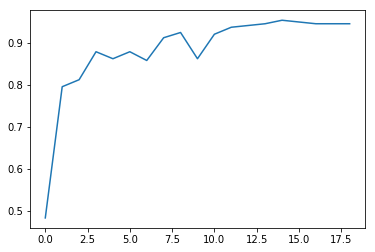

Максимум точности =  0.95416665


In [ ]:
global epochs
epochs = 30
model = create_model()
history = model.fit(x_train_dataset, 
                    y_train, 
                    batch_size=15, 
                    epochs=epochs,  
                    verbose=1, 
                    validation_split=0.2,
                   callbacks = callbacks)

plt.plot(history.history['val_acc'])
plt.show()
print("Максимум точности = ", max(history.history['val_acc']))

Протестируем сеть

(150, 64, 64, 1)
Точность по тестовой выборке = : 97.0 %
Поищем эти картинки для контроля
(64, 64, 1)


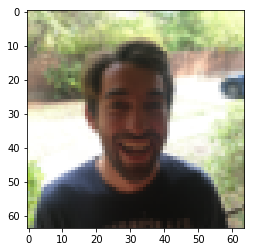

Проверочный класс =  1
Класс предсказаный =  0
(64, 64, 1)


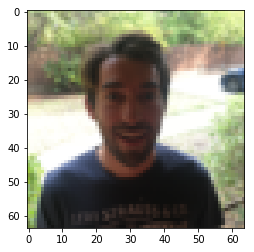

Проверочный класс =  0
Класс предсказаный =  1
(64, 64, 1)


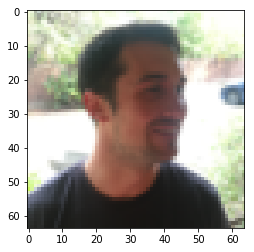

Проверочный класс =  1
Класс предсказаный =  0
(64, 64, 1)


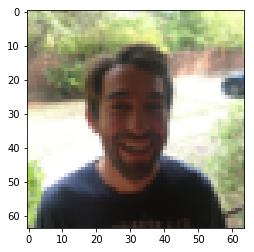

Проверочный класс =  1
Класс предсказаный =  0
(64, 64, 1)


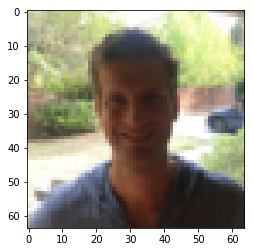

Проверочный класс =  1
Класс предсказаный =  0


In [ ]:
x_test_dataset = convertdataset(x_test)

accuracy_nn = round(model.evaluate(x_test_dataset,y_test,verbose = 0)[1]*100)
print('Точность по тестовой выборке = :',accuracy_nn,'%')
print('Поищем эти картинки для контроля')
x_predict = model.predict(x_test_dataset)
for i in range(x_test_dataset.shape[0]):
    if x_predict[i] > 0.5:
        result = 1
    else:
        result = 0
        
    if y_test[i] != result:
        print(x_test_dataset[i][:,:].shape)
        plt.imshow(x_test[i])
        plt.show()
        print('Проверочный класс = ', y_test[i])
        print('Класс предсказаный = ', result)
        

# 2 часть

## Пред обработка данных из второго датасета


In [ ]:
f_csv = np.loadtxt('olivetti_X.csv', delimiter=',')
f2_csv = np.loadtxt('olivetti_y.csv', delimiter=',')
oln = np.reshape(f_csv,(f_csv.shape[0],64,64))

### Разметка картинок и сверка с общей разметкой

Для разметки использую модуль dlib и потом сверяю результат работы с датасетами от других студентов. 
Это даст усредненный вариант.

In [ ]:

!cp /content/drive/My\ Drive/Colab\ Notebooks/Курс\ нейросетей/Курсовая/olivetti_y2.csv './'
oli_y2 = np.loadtxt('olivetti_y2.csv', delimiter=',')


def smile(mouth):
    A = dist.euclidean(mouth[3], mouth[9])
    B = dist.euclidean(mouth[2], mouth[10])
    C = dist.euclidean(mouth[4], mouth[8])
    avg = (A+B+C)/3
    D = dist.euclidean(mouth[0], mouth[6])
    mar=avg/D
    return mar

COUNTER = 0
TOTAL = 0


shape_predictor= "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]


mar= 0.24523408679850528
угол =  0.12565513657513097


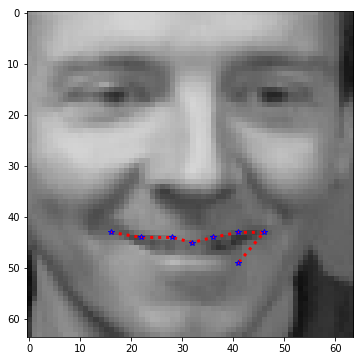

In [ ]:
i = 20
img = np.concatenate((oln[i][:,:,np.newaxis]*255, oln[i][:,:,np.newaxis]*255,oln[i][:,:,np.newaxis]*255), axis=2).astype(np.uint8)
rects = detector(img, 0)
for rect in rects:
    shape = predictor(img, rect)
    shape = face_utils.shape_to_np(shape)
    mouth= shape[mStart:mEnd]
    mar= smile(mouth)
    mouthHull = cv2.convexHull(mouth)
    #print(shape)
    #cv2.drawContours(img, [mouthHull], -1, (0, 255, 0), 1)
print('mar=',mar)
plt.figure(figsize=(6,6))
plt.imshow(img)
#plt.plot(*zip(*mouthHull[:,0].tolist()))
plt.plot(*zip(*shape[48:56].tolist()), c='r', marker="*", ls=':', mec='b',linewidth=3)
print('угол = ', math.tan((shape[51][1] - shape[48][1])/(shape[51][0] - shape[48][0])))

По данным из модуля  нашел, что необходимы 48 и 51 точки.
функция расчета mar для определения улыбки не всегда верно расчитывается, так как у людей ее работа весьма индивидуальна. 

Для определения улыбки буду использовать угол наклона губ, а в сложных местах учитывать mar.

In [ ]:
import math
olivet_y2 = []

for i in range(oln.shape[0]):
    img = np.concatenate((oln[i][:,:,np.newaxis]*255, oln[i][:,:,np.newaxis]*255,oln[i][:,:,np.newaxis]*255), axis=2).astype(np.uint8)
    rects = detector(img, 0)
    for rect in rects:
        shape = predictor(img, rect)
        shape = face_utils.shape_to_np(shape)
        mouth= shape[mStart:mEnd]
        mar= smile(mouth)
        mouthHull = cv2.convexHull(mouth)
        
    angl = math.tan((shape[51][1] - shape[48][1])/(shape[51][0] - shape[48][0]))    
    if angl >= -0.06:
        if mar > 0.16:
            olivet_y2.append(1)
        else:
            olivet_y2.append(0)
        #print('Улыбка')
    else:
        if mar > 0.4 and angl >= -0.2:
            olivet_y2.append(1)
        else:
            olivet_y2.append(0)
    #if mar < 0.olivet_y2.append(0)
    #print('mar=',mar)
    #print('угол = ', angl)
    #print(i)
    #plt.imshow(img)
    #plt.plot(*zip(*shape[48:61].tolist()), c='r', marker="*", ls=':', mec='b',linewidth=3)
    #plt.show()


Произвожу сравнение двух размеченных датасетов для приведения его к среднему виду.

значение i = 9 мой =  1 дали =  0
mar= 0.25552944576635334
угол =  0.0


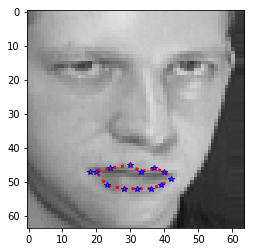

значение i = 22 мой =  1 дали =  0
mar= 0.2574713144910028
угол =  0.0


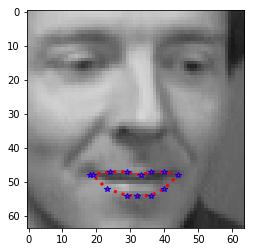

значение i = 23 мой =  1 дали =  0
mar= 0.22007083411021072
угол =  0.0


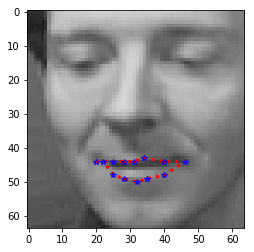

значение i = 25 мой =  1 дали =  0
mar= 0.21154119995649118
угол =  0.07155029701646888


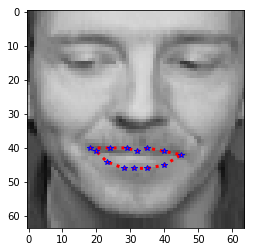

значение i = 28 мой =  1 дали =  0
mar= 0.23726059069858638
угол =  0.07707515893586198


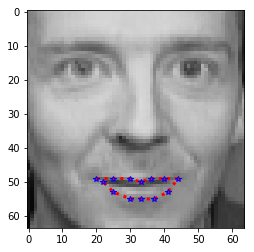

значение i = 29 мой =  1 дали =  0
mar= 0.3474977942104555
угол =  0.0


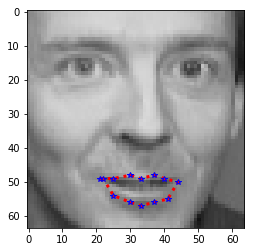

значение i = 40 мой =  0 дали =  1
mar= 0.27854298512047726
угол =  -0.15507153273705318


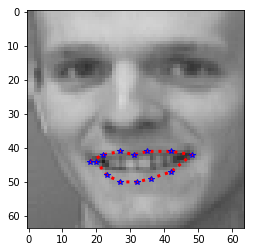

значение i = 41 мой =  0 дали =  1
mar= 0.28128409723243836
угол =  -0.12565513657513097


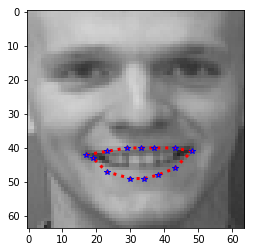

значение i = 42 мой =  0 дали =  1
mar= 0.2692726795988258
угол =  -0.11819285841535332


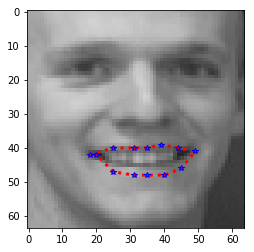

значение i = 43 мой =  0 дали =  1
mar= 0.2921010025504407
угол =  -0.15507153273705318


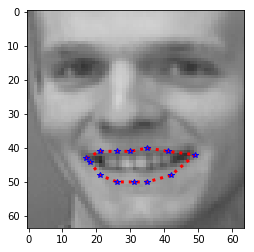

значение i = 45 мой =  0 дали =  1
mar= 0.23191921595086784
угол =  -0.08352677191506926


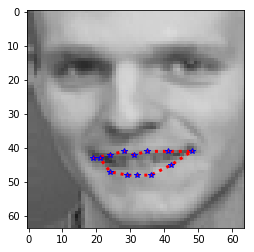

значение i = 46 мой =  0 дали =  1
mar= 0.3258663415980022
угол =  -0.16822721830224246


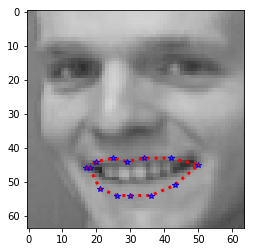

значение i = 48 мой =  0 дали =  1
mar= 0.20863703354080235
угол =  -0.07155029701646888


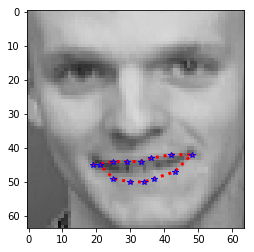

значение i = 49 мой =  0 дали =  1
mar= 0.27455068747974465
угол =  -0.23495491107528804


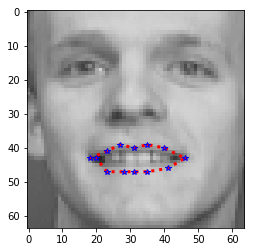

значение i = 60 мой =  0 дали =  1
mar= 0.2034300589005778
угол =  -0.07155029701646888


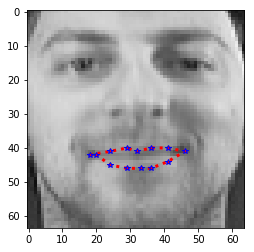

значение i = 61 мой =  0 дали =  1
mar= 0.4508539118485121
угол =  -0.25534192122103627


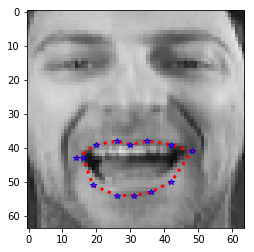

значение i = 62 мой =  0 дали =  1
mar= 0.28853704586580536
угол =  -0.13412911616973258


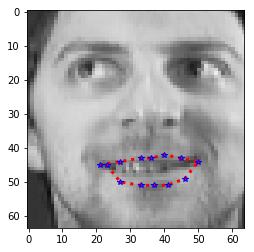

значение i = 63 мой =  1 дали =  0
mar= 0.2
угол =  0.08352677191506926


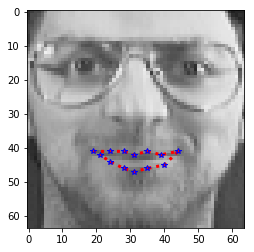

значение i = 65 мой =  0 дали =  1
mar= 0.42053827611125294
угол =  -0.2937513616198622


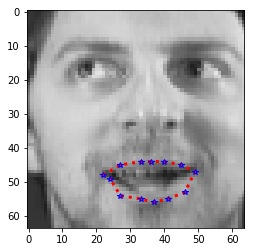

значение i = 69 мой =  0 дали =  1
mar= 0.3139053764526082
угол =  -0.06258150756627502


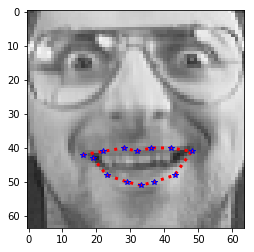

значение i = 70 мой =  0 дали =  1
mar= 0.4523809523809524
угол =  -0.3177848961576365


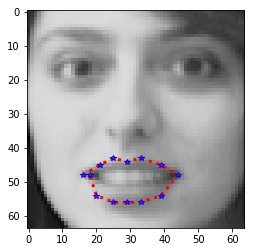

значение i = 71 мой =  0 дали =  1
mar= 0.375443473566172
угол =  -0.16822721830224246


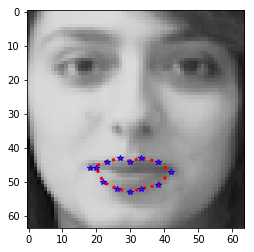

значение i = 72 мой =  0 дали =  1
mar= 0.42053827611125294
угол =  -0.2176269813251559


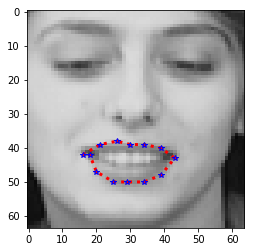

значение i = 74 мой =  0 дали =  1
mar= 0.35932420690442357
угол =  -0.2027100355086725


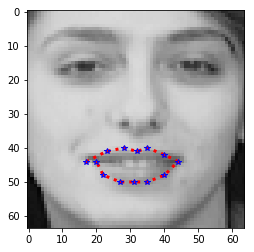

значение i = 75 мой =  0 дали =  1
mar= 0.48942222050155076
угол =  -0.2027100355086725


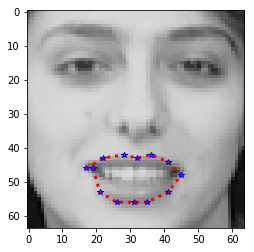

значение i = 77 мой =  0 дали =  1
mar= 0.28072308211877095
угол =  -0.15507153273705318


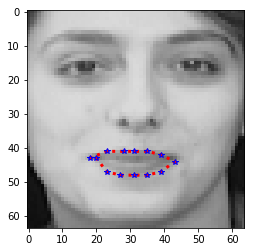

значение i = 80 мой =  1 дали =  0
mar= 0.234912618041455
угол =  0.12565513657513097


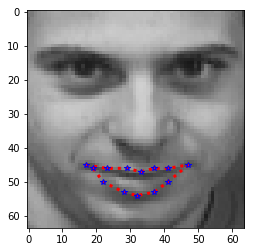

значение i = 81 мой =  1 дали =  0
mar= 0.25908162356916187
угол =  0.0


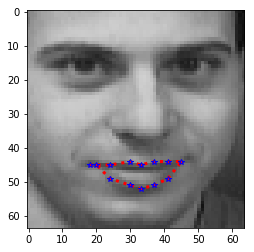

значение i = 82 мой =  1 дали =  0
mar= 0.22301186457628305
угол =  0.12565513657513097


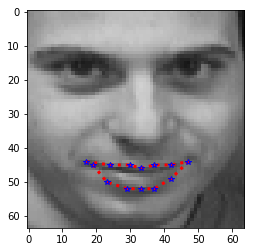

значение i = 83 мой =  1 дали =  0
mar= 0.25227433592305315
угол =  0.0


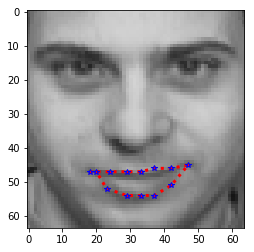

значение i = 84 мой =  1 дали =  0
mar= 0.26041430221709283
угол =  0.0


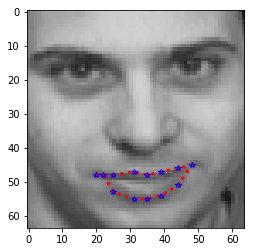

значение i = 85 мой =  1 дали =  0
mar= 0.2508460453793509
угол =  0.07707515893586198


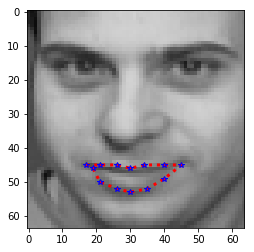

значение i = 86 мой =  1 дали =  0
mar= 0.26518468749270663
угол =  0.08352677191506926


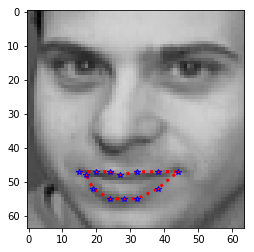

значение i = 88 мой =  1 дали =  0
mar= 0.22604635991194572
угол =  0.07155029701646888


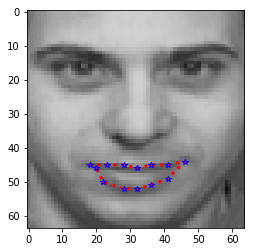

значение i = 94 мой =  1 дали =  0
mar= 0.2308922924100086
угол =  0.06676560799818931


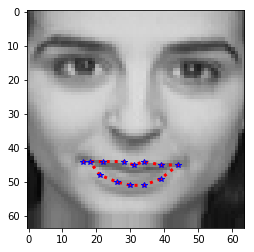

значение i = 95 мой =  1 дали =  0
mar= 0.22097892326276894
угол =  0.06676560799818931


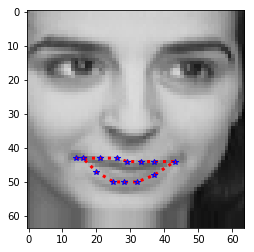

значение i = 96 мой =  1 дали =  0
mar= 0.25068621991210305
угол =  0.06258150756627502


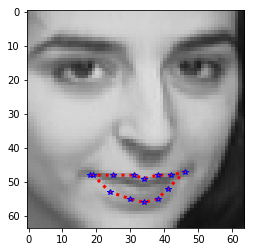

значение i = 97 мой =  1 дали =  0
mar= 0.2152709825035502
угол =  0.13412911616973258


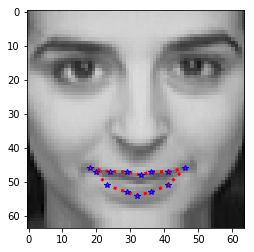

значение i = 98 мой =  1 дали =  0
mar= 0.22604635991194572
угол =  0.2027100355086725


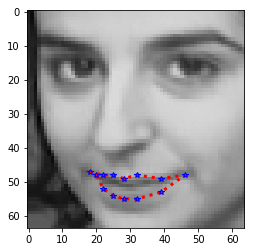

значение i = 100 мой =  0 дали =  1
mar= 0.30642162734134876
угол =  -0.48867354171937216


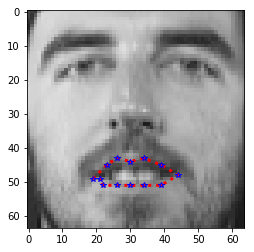

значение i = 112 мой =  0 дали =  1
mar= 0.34615384615384615
угол =  -0.08352677191506926


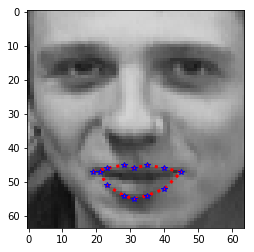

значение i = 113 мой =  0 дали =  1
mar= 0.37222989847463667
угол =  -0.07155029701646888


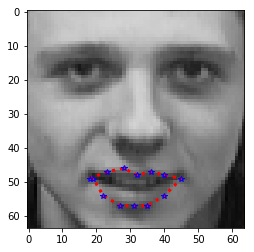

значение i = 117 мой =  0 дали =  1
mar= 0.3482352384858129
угол =  -0.06676560799818931


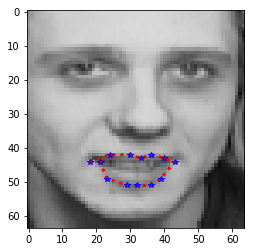

значение i = 120 мой =  1 дали =  0
mar= 0.2075900412172858
угол =  0.0


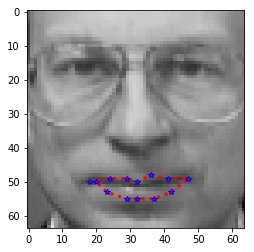

значение i = 121 мой =  1 дали =  0
mar= 0.195286229758747
угол =  0.0


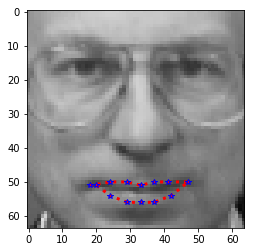

значение i = 122 мой =  0 дали =  1
mar= 0.14209947468765452
угол =  -0.07155029701646888


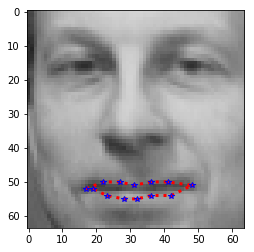

значение i = 125 мой =  1 дали =  0
mar= 0.22787650669563583
угол =  -0.05268023080512177


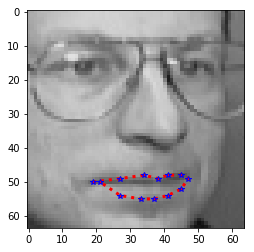

значение i = 141 мой =  0 дали =  1
mar= 0.24813290282754413
угол =  -0.23495491107528804


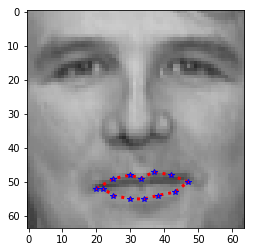

значение i = 146 мой =  0 дали =  1
mar= 0.3814923930617531
угол =  -0.2937513616198622


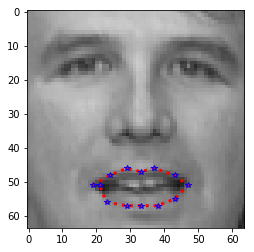

значение i = 153 мой =  0 дали =  1
mar= 0.3333333333333333
угол =  -0.3177848961576365


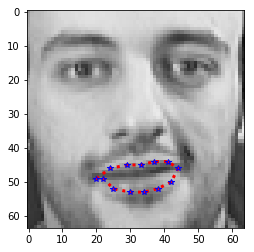

значение i = 154 мой =  0 дали =  1
mar= 0.3201106372330177
угол =  -0.2937513616198622


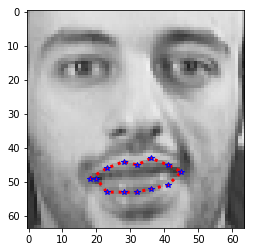

значение i = 164 мой =  0 дали =  1
mar= 0.12532354275873925
угол =  0.0


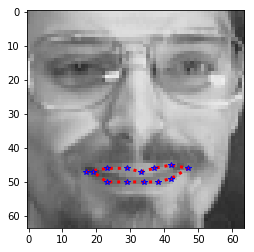

значение i = 165 мой =  1 дали =  0
mar= 0.24538050008204357
угол =  0.0


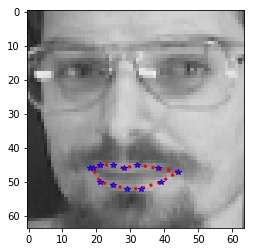

значение i = 167 мой =  1 дали =  0
mar= 0.24358974358974358
угол =  0.0


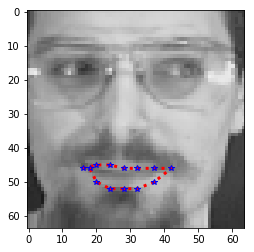

значение i = 168 мой =  1 дали =  0
mar= 0.19753086419753085
угол =  0.0


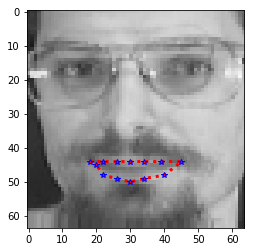

значение i = 173 мой =  0 дали =  1
mar= 0.48195561494327527
угол =  -0.2176269813251559


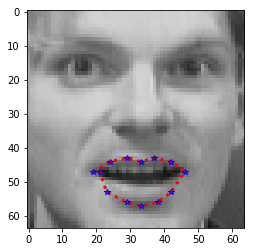

значение i = 174 мой =  0 дали =  1
mar= 0.2546181178410448
угол =  -0.14383695943619093


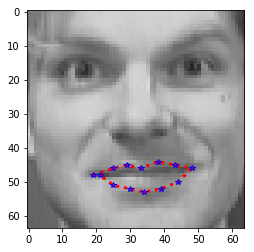

значение i = 187 мой =  0 дали =  1
mar= 0.24023185154477655
угол =  -0.12565513657513097


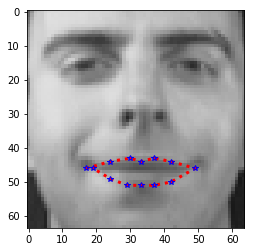

значение i = 188 мой =  0 дали =  1
mar= 0.2373233098050051
угол =  -0.12565513657513097


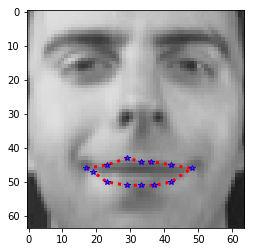

значение i = 190 мой =  0 дали =  1
mar= 0.36227052200385995
угол =  -0.15922009995792513


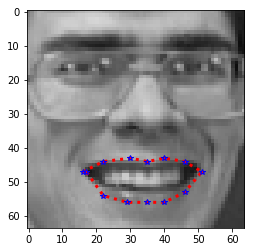

значение i = 191 мой =  0 дали =  1
mar= 0.2907076642868017
угол =  -0.18972861071805913


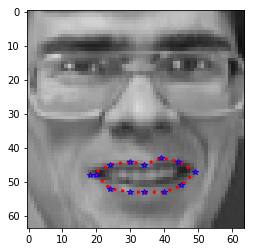

значение i = 193 мой =  0 дали =  1
mar= 0.10717879678548001
угол =  -0.07155029701646888


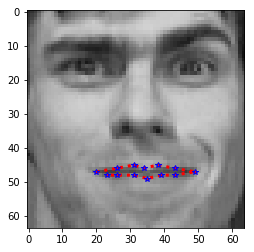

значение i = 195 мой =  0 дали =  1
mar= 0.12797274256027125
угол =  0.0


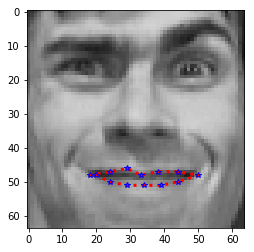

значение i = 204 мой =  1 дали =  0
mar= 0.3072510673651857
угол =  0.0


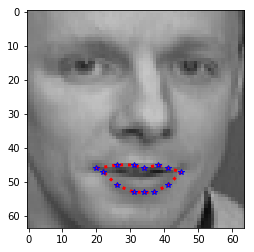

значение i = 206 мой =  1 дали =  0
mar= 0.2022520062370041
угол =  0.0


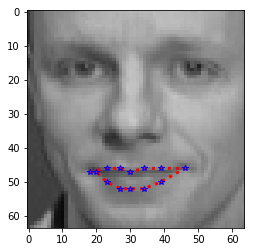

значение i = 207 мой =  1 дали =  0
mar= 0.46629378073683503
угол =  -0.18384853989658834


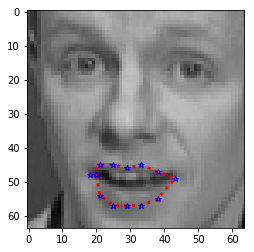

значение i = 208 мой =  1 дали =  0
mar= 0.43581654845676815
угол =  -0.15507153273705318


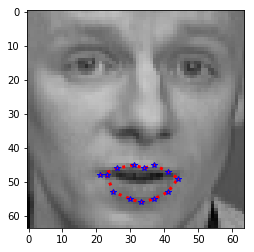

значение i = 210 мой =  0 дали =  1
mar= 0.37314069695921875
угол =  -0.1783255733662755


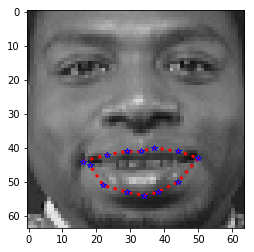

значение i = 211 мой =  0 дали =  1
mar= 0.37694105963471897
угол =  -0.27317277996474193


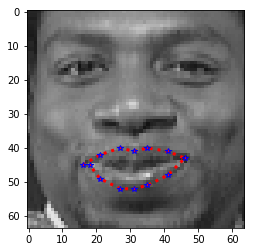

значение i = 212 мой =  0 дали =  1
mar= 0.34419273232480957
угол =  -0.11819285841535332


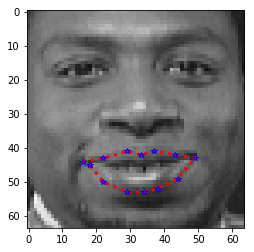

значение i = 213 мой =  0 дали =  1
mar= 0.4382335121287744
угол =  -0.34625354951057546


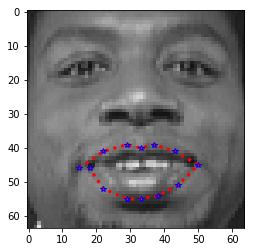

значение i = 214 мой =  0 дали =  1
mar= 0.39655155764502015
угол =  -0.16822721830224246


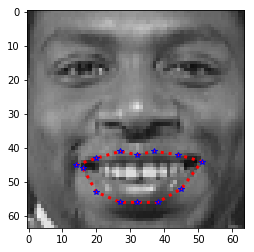

значение i = 216 мой =  0 дали =  1
mar= 0.4184870529968644
угол =  -0.22595393133353248


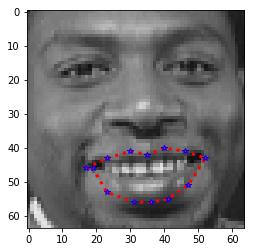

значение i = 217 мой =  0 дали =  1
mar= 0.29523148340530436
угол =  -0.16822721830224246


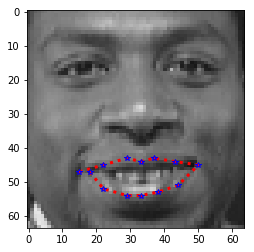

значение i = 219 мой =  0 дали =  1
mar= 0.3129284826980514
угол =  -0.2027100355086725


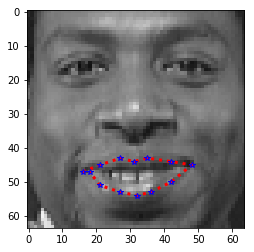

значение i = 222 мой =  1 дали =  0
mar= 0.21197542798775015
угол =  0.0


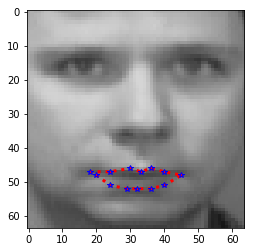

значение i = 228 мой =  1 дали =  0
mar= 0.16091954022988506
угол =  0.0


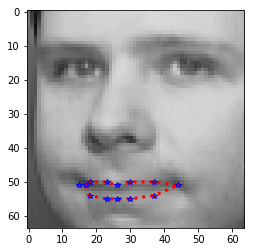

значение i = 229 мой =  1 дали =  0
mar= 0.16196143318261985
угол =  0.0


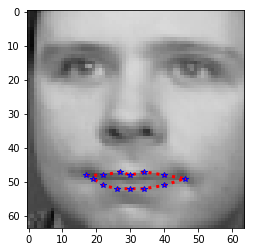

значение i = 234 мой =  0 дали =  1
mar= 0.24509795906844997
угол =  -0.06676560799818931


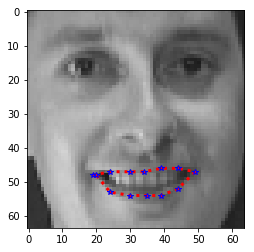

значение i = 235 мой =  1 дали =  0
mar= 0.22909042725188006
угол =  0.0


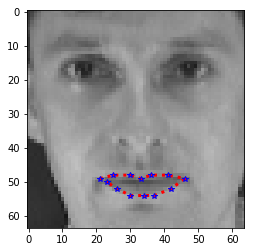

значение i = 237 мой =  0 дали =  1
mar= 0.15189450667735757
угол =  -0.07155029701646888


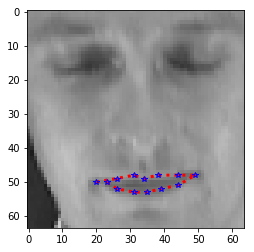

значение i = 240 мой =  0 дали =  1
mar= 0.13125288210999958
угол =  0.05889147065772838


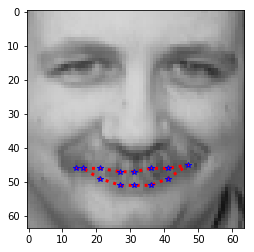

значение i = 241 мой =  1 дали =  0
mar= 0.18148998073566516
угол =  0.0


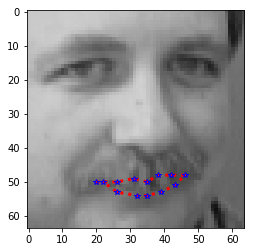

значение i = 242 мой =  0 дали =  1
mar= 0.14134925765692263
угол =  0.05889147065772838


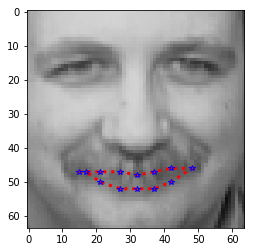

значение i = 244 мой =  1 дали =  0
mar= 0.18210783977117087
угол =  0.0


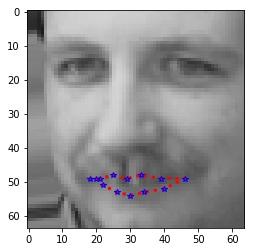

значение i = 246 мой =  0 дали =  1
mar= 0.12628235026685064
угол =  0.12565513657513097


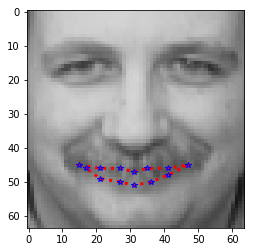

значение i = 249 мой =  0 дали =  1
mar= 0.14084967218916972
угол =  0.11819285841535332


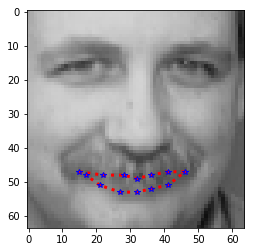

значение i = 253 мой =  0 дали =  1
mar= 0.11093588357682588
угол =  -0.05889147065772838


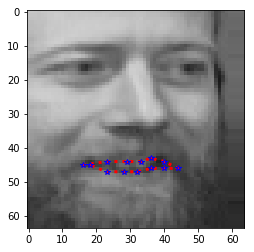

значение i = 255 мой =  0 дали =  1
mar= 0.14540878411088443
угол =  0.0


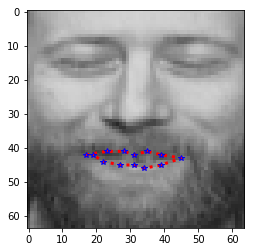

значение i = 257 мой =  0 дали =  1
mar= 0.1959841934073786
угол =  -0.13412911616973258


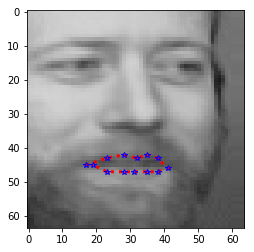

значение i = 258 мой =  0 дали =  1
mar= 0.13771147709172424
угол =  -0.07155029701646888


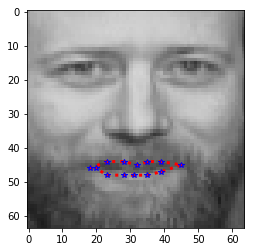

значение i = 263 мой =  0 дали =  1
mar= 0.3220433589155053
угол =  -0.06676560799818931


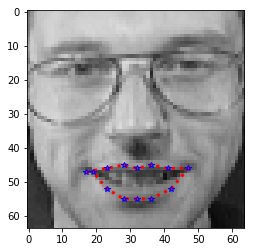

значение i = 265 мой =  1 дали =  0
mar= 0.3107262159978407
угол =  0.07707515893586198


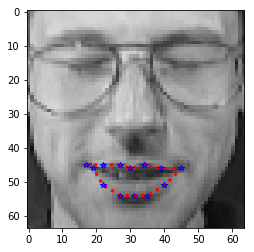

значение i = 266 мой =  1 дали =  0
mar= 0.195286229758747
угол =  0.06676560799818931


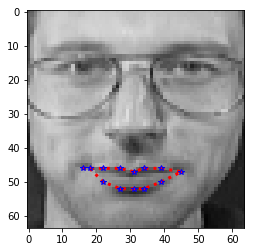

значение i = 269 мой =  1 дали =  0
mar= 0.20791113430232505
угол =  0.06676560799818931


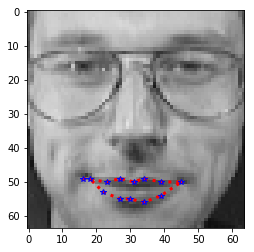

значение i = 271 мой =  0 дали =  1
mar= 0.23083635092296803
угол =  -0.06676560799818931


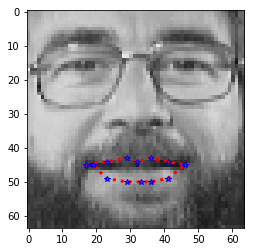

значение i = 273 мой =  0 дали =  1
mar= 0.1057939029253981
угол =  -0.07707515893586198


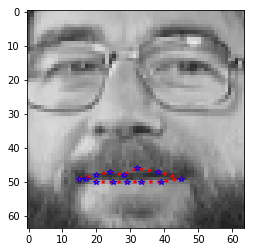

значение i = 274 мой =  0 дали =  1
mar= 0.15045937205113757
угол =  0.0


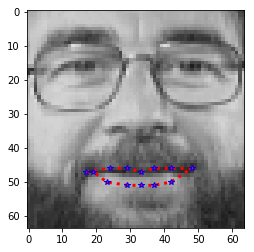

значение i = 276 мой =  0 дали =  1
mar= 0.20476528703246846
угол =  -0.06258150756627502


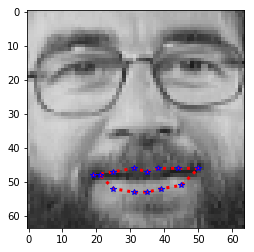

значение i = 279 мой =  1 дали =  0
mar= 0.20476528703246846
угол =  -0.06258150756627502


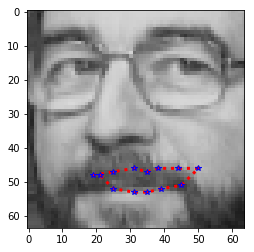

значение i = 288 мой =  1 дали =  0
mar= 0.31697765506131054
угол =  0.0


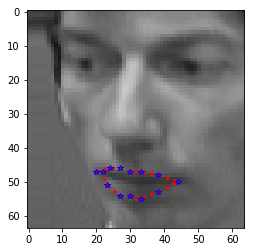

значение i = 300 мой =  1 дали =  0
mar= 0.29882903916036985
угол =  0.0


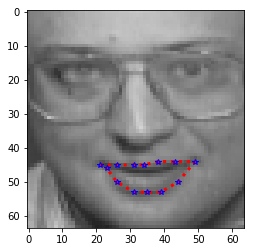

значение i = 302 мой =  0 дали =  1
mar= 0.19844304108263475
угол =  -0.12565513657513097


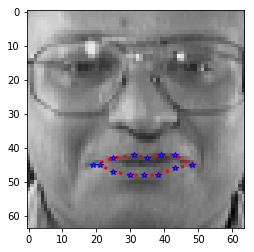

значение i = 303 мой =  0 дали =  1
mar= 0.3454008692082861
угол =  -0.13412911616973258


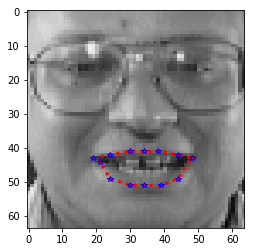

значение i = 307 мой =  1 дали =  0
mar= 0.2780088878723638
угол =  0.07707515893586198


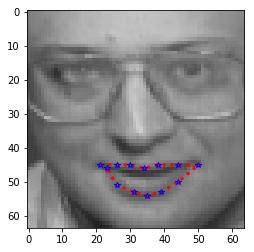

значение i = 310 мой =  0 дали =  1
mar= 0.482429748405069
угол =  -0.4227932187381618


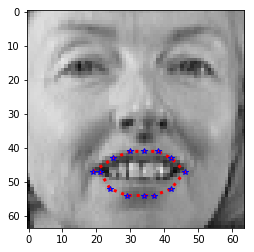

значение i = 311 мой =  0 дали =  1
mar= 0.48
угол =  -0.34625354951057546


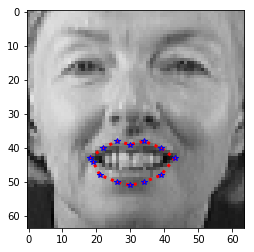

значение i = 312 мой =  0 дали =  1
mar= 0.41735938362667907
угол =  -0.25534192122103627


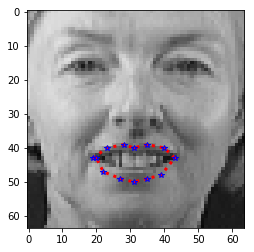

значение i = 314 мой =  0 дали =  1
mar= 0.4460101959244441
угол =  -0.2937513616198622


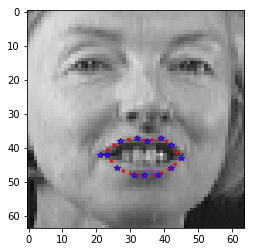

значение i = 316 мой =  0 дали =  1
mar= 0.4635618631625331
угол =  -0.47622143322449434


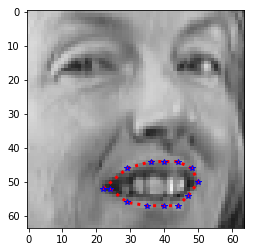

значение i = 322 мой =  0 дали =  1
mar= 0.3798317358297386
угол =  -0.13412911616973258


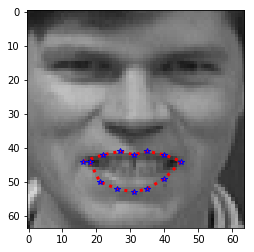

значение i = 323 мой =  0 дали =  1
mar= 0.3798317358297386
угол =  -0.13412911616973258


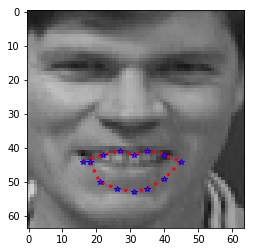

значение i = 324 мой =  0 дали =  1
mar= 0.3566213223640315
угол =  -0.2027100355086725


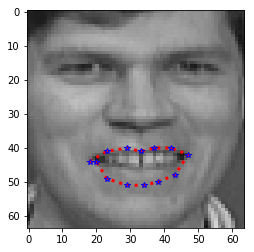

значение i = 325 мой =  0 дали =  1
mar= 0.32258473879832533
угол =  -0.3177848961576365


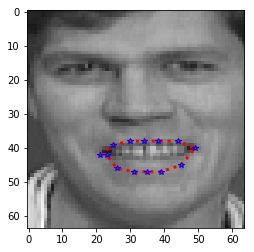

значение i = 326 мой =  0 дали =  1
mar= 0.34462275839778883
угол =  -0.2027100355086725


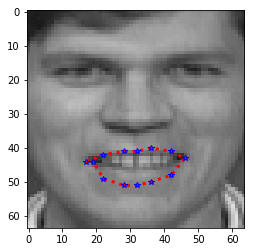

значение i = 327 мой =  0 дали =  1
mar= 0.34462275839778883
угол =  -0.2027100355086725


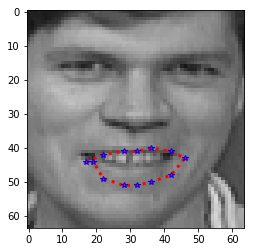

значение i = 328 мой =  0 дали =  1
mar= 0.3343938243239293
угол =  -0.2176269813251559


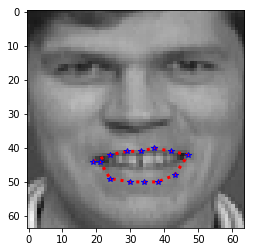

значение i = 340 мой =  0 дали =  1
mar= 0.2784695305366505
угол =  -0.06676560799818931


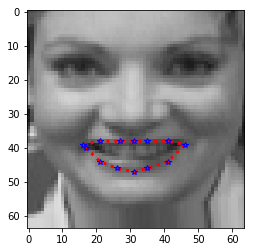

значение i = 348 мой =  0 дали =  1
mar= 0.36766774546973857
угол =  -0.09116035984988625


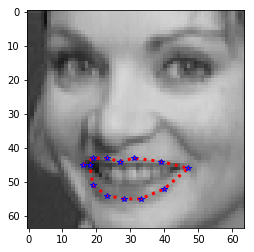

значение i = 349 мой =  0 дали =  1
mar= 0.30280264405801854
угол =  -0.08352677191506926


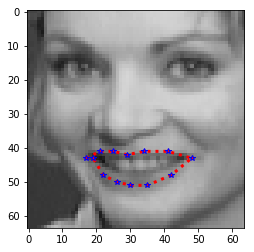

значение i = 350 мой =  0 дали =  1
mar= 0.24085456518164408
угол =  -0.3029026532233357


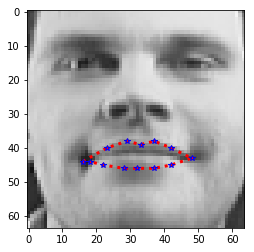

значение i = 354 мой =  0 дали =  1
mar= 0.22905485076995555
угол =  -0.32308624435174554


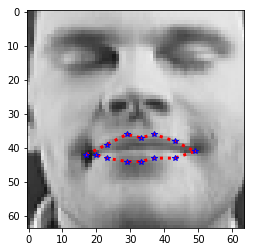

значение i = 361 мой =  0 дали =  1
mar= 0.22970305255385548
угол =  -0.06258150756627502


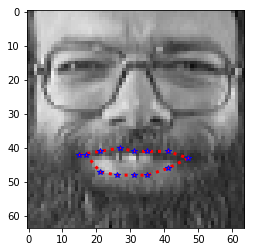

значение i = 363 мой =  0 дали =  1
mar= 0.1913394698580077
угол =  -0.14383695943619093


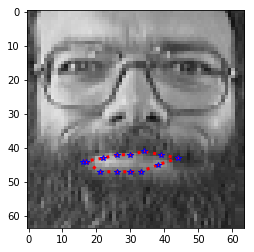

значение i = 364 мой =  0 дали =  1
mar= 0.20673754885671486
угол =  -0.12565513657513097


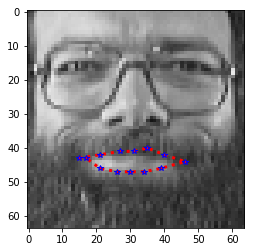

значение i = 367 мой =  0 дали =  1
mar= 0.20673754885671486
угол =  -0.12565513657513097


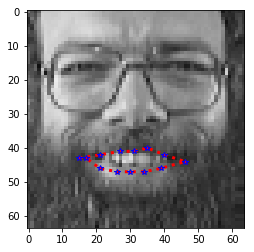

значение i = 368 мой =  0 дали =  1
mar= 0.17394270791975774
угол =  -0.14383695943619093


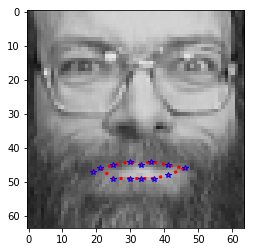

значение i = 369 мой =  0 дали =  1
mar= 0.21526447862129186
угол =  -0.25534192122103627


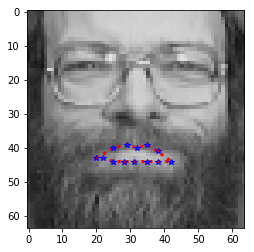

значение i = 380 мой =  0 дали =  1
mar= 0.09517741469976662
угол =  0.0


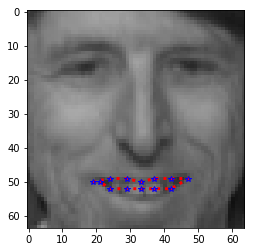

значение i = 381 мой =  0 дали =  1
mar= 0.11098534863604861
угол =  -0.15507153273705318


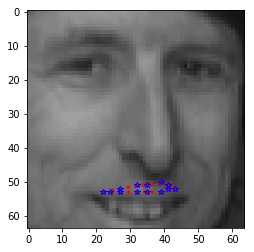

значение i = 382 мой =  0 дали =  1
mar= 0.19984019174435788
угол =  -0.11157062783380058


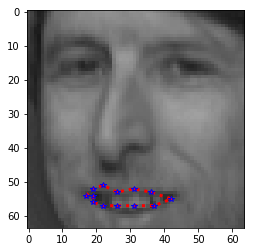

значение i = 385 мой =  0 дали =  1
mar= 0.1570354509352789
угол =  0.15507153273705318


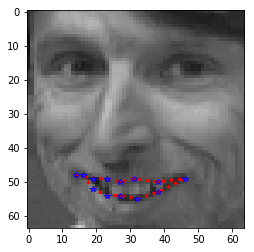

значение i = 388 мой =  0 дали =  1
mar= 0.14814814814814814
угол =  0.07155029701646888


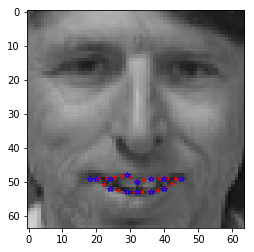

значение i = 391 мой =  0 дали =  1
mar= 0.4544927412797275
угол =  -0.23495491107528804


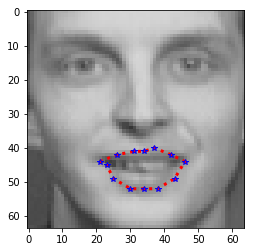

значение i = 392 мой =  1 дали =  0
mar= 0.42334546495064596
угол =  -0.14383695943619093


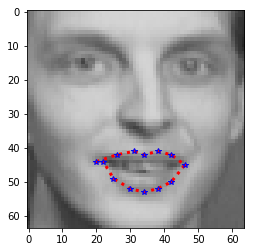

значение i = 393 мой =  0 дали =  1
mar= 0.3675976089576414
угол =  -0.08352677191506926


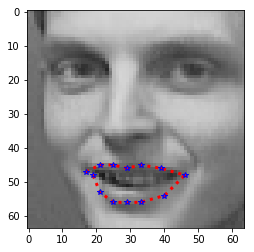

значение i = 395 мой =  0 дали =  1
mar= 0.30941058948516725
угол =  -0.06676560799818931


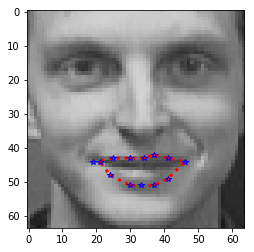

137


In [ ]:
def compare(oln, olivet_y2, oli_y2):
    x=0
    for i in range(oli_y2.shape[0]):
        if int(oli_y2[i]) != olivet_y2[i]:
            x = x+1
            print('значение i =', i ,'мой = ', olivet_y2[i], 'дали = ', int(oli_y2[i]))
            img = np.concatenate((oln[i][:,:,np.newaxis]*255, oln[i][:,:,np.newaxis]*255,oln[i][:,:,np.newaxis]*255), axis=2).astype(np.uint8)
            rects = detector(img, 0)
            for rect in rects:
                shape = predictor(img, rect)
                shape = face_utils.shape_to_np(shape)
                mouth= shape[mStart:mEnd]
                mar= smile(mouth)
                mouthHull = cv2.convexHull(mouth)
                #print(shape)
                #cv2.drawContours(img, [mouthHull], -1, (0, 255, 0), 1)
            angl = math.tan((shape[51][1] - shape[48][1])/(shape[51][0] - shape[48][0]))
            print('mar=',mar)
            print('угол = ', angl)
            plt.imshow(img)
            plt.plot(*zip(*shape[48:61].tolist()), c='r', marker="*", ls=':', mec='b',linewidth=3)
            plt.show()
    print(x)
    
    
compare(oln, olivet_y2, oli_y2)   

Копирую разметку, с которой программа не справилась сама.
Не совпало 137 фото из 400. 

Считаю, что моя функция справилась с работой хорошо, так как смогла отсортировать сама 263 фото или 66%

значение i = 9 мой =  1 дали =  0
mar= 0.25552944576635334
угол =  0.0


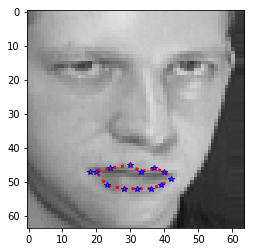

значение i = 22 мой =  1 дали =  0
mar= 0.2574713144910028
угол =  0.0


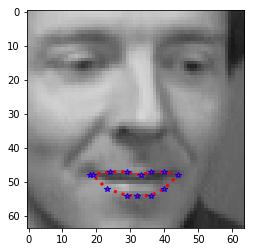

значение i = 23 мой =  1 дали =  0
mar= 0.22007083411021072
угол =  0.0


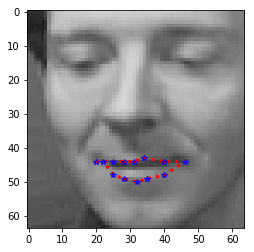

значение i = 45 мой =  0 дали =  1
mar= 0.23191921595086784
угол =  -0.08352677191506926


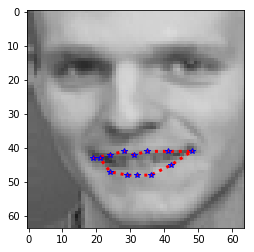

значение i = 63 мой =  1 дали =  0
mar= 0.2
угол =  0.08352677191506926


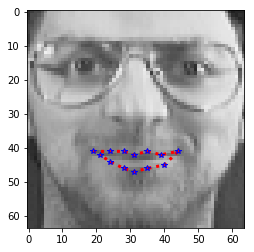

значение i = 71 мой =  0 дали =  1
mar= 0.375443473566172
угол =  -0.16822721830224246


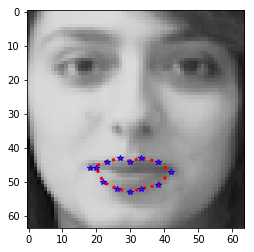

значение i = 80 мой =  1 дали =  0
mar= 0.234912618041455
угол =  0.12565513657513097


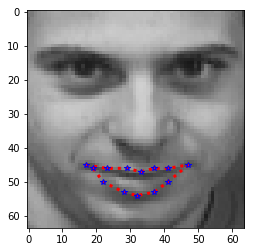

значение i = 81 мой =  1 дали =  0
mar= 0.25908162356916187
угол =  0.0


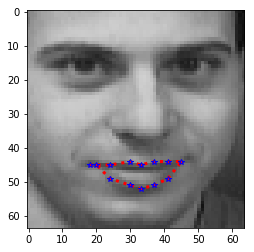

значение i = 82 мой =  1 дали =  0
mar= 0.22301186457628305
угол =  0.12565513657513097


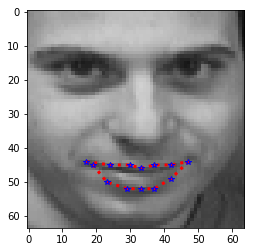

значение i = 83 мой =  1 дали =  0
mar= 0.25227433592305315
угол =  0.0


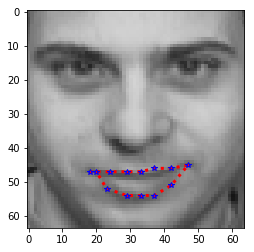

значение i = 85 мой =  1 дали =  0
mar= 0.2508460453793509
угол =  0.07707515893586198


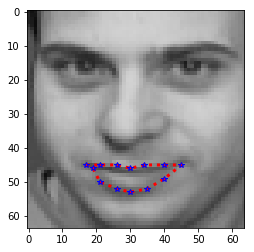

значение i = 88 мой =  1 дали =  0
mar= 0.22604635991194572
угол =  0.07155029701646888


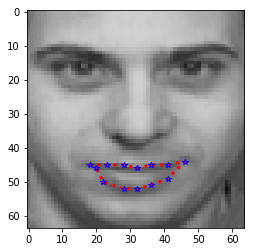

значение i = 94 мой =  1 дали =  0
mar= 0.2308922924100086
угол =  0.06676560799818931


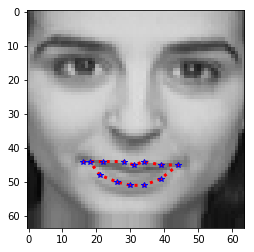

значение i = 95 мой =  1 дали =  0
mar= 0.22097892326276894
угол =  0.06676560799818931


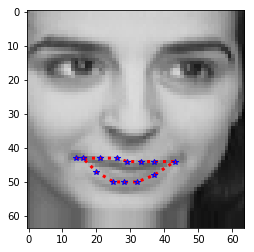

значение i = 97 мой =  1 дали =  0
mar= 0.2152709825035502
угол =  0.13412911616973258


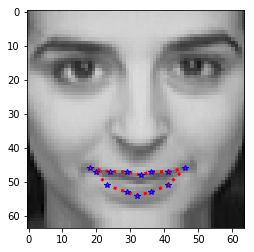

значение i = 98 мой =  1 дали =  0
mar= 0.22604635991194572
угол =  0.2027100355086725


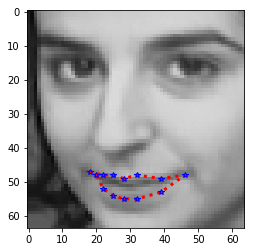

значение i = 100 мой =  0 дали =  1
mar= 0.30642162734134876
угол =  -0.48867354171937216


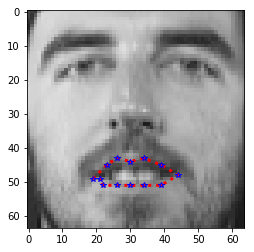

значение i = 113 мой =  0 дали =  1
mar= 0.37222989847463667
угол =  -0.07155029701646888


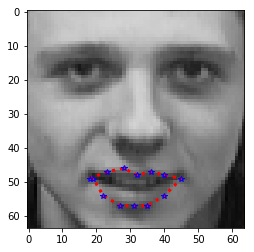

значение i = 117 мой =  0 дали =  1
mar= 0.3482352384858129
угол =  -0.06676560799818931


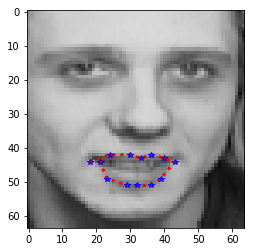

значение i = 122 мой =  0 дали =  1
mar= 0.14209947468765452
угол =  -0.07155029701646888


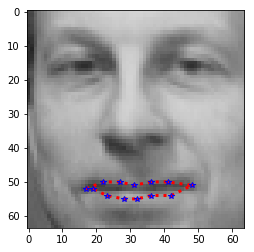

значение i = 141 мой =  0 дали =  1
mar= 0.24813290282754413
угол =  -0.23495491107528804


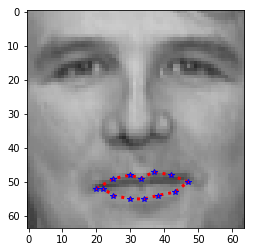

значение i = 146 мой =  0 дали =  1
mar= 0.3814923930617531
угол =  -0.2937513616198622


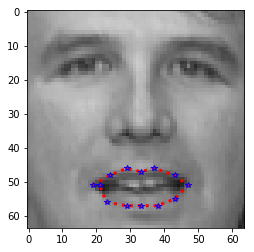

значение i = 153 мой =  0 дали =  1
mar= 0.3333333333333333
угол =  -0.3177848961576365


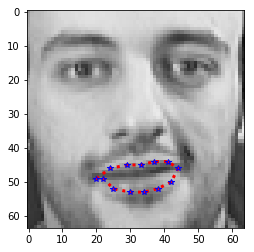

значение i = 154 мой =  0 дали =  1
mar= 0.3201106372330177
угол =  -0.2937513616198622


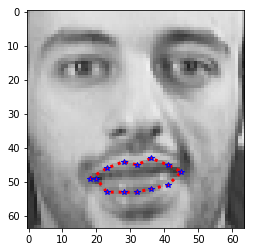

значение i = 165 мой =  1 дали =  0
mar= 0.24538050008204357
угол =  0.0


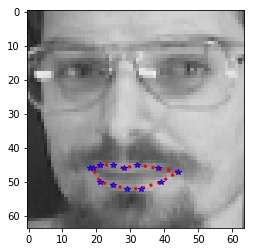

значение i = 167 мой =  1 дали =  0
mar= 0.24358974358974358
угол =  0.0


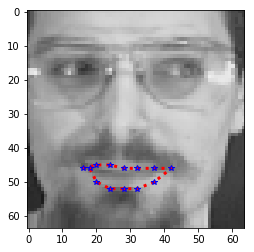

значение i = 173 мой =  0 дали =  1
mar= 0.48195561494327527
угол =  -0.2176269813251559


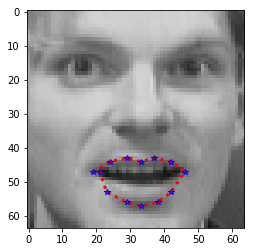

значение i = 193 мой =  0 дали =  1
mar= 0.10717879678548001
угол =  -0.07155029701646888


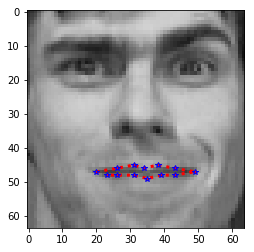

значение i = 195 мой =  0 дали =  1
mar= 0.12797274256027125
угол =  0.0


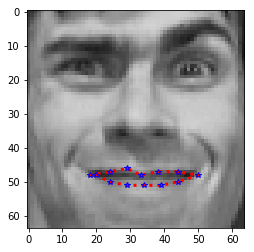

значение i = 210 мой =  0 дали =  1
mar= 0.37314069695921875
угол =  -0.1783255733662755


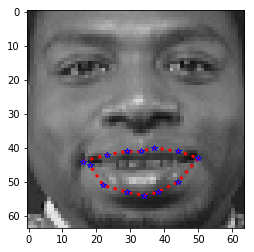

значение i = 213 мой =  0 дали =  1
mar= 0.4382335121287744
угол =  -0.34625354951057546


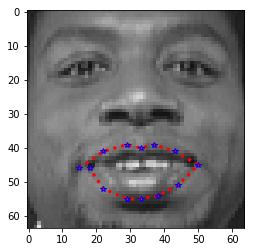

значение i = 253 мой =  0 дали =  1
mar= 0.11093588357682588
угол =  -0.05889147065772838


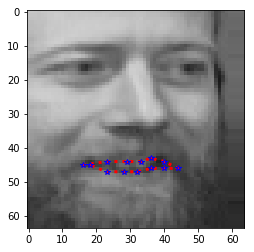

значение i = 257 мой =  0 дали =  1
mar= 0.1959841934073786
угол =  -0.13412911616973258


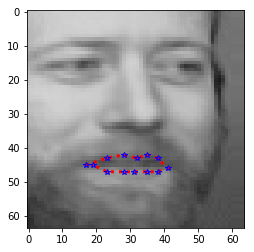

значение i = 258 мой =  0 дали =  1
mar= 0.13771147709172424
угол =  -0.07155029701646888


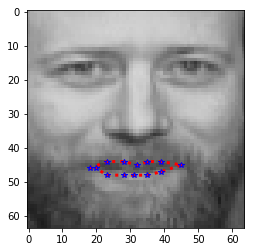

значение i = 266 мой =  1 дали =  0
mar= 0.195286229758747
угол =  0.06676560799818931


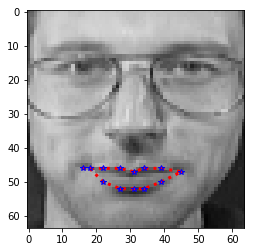

значение i = 269 мой =  1 дали =  0
mar= 0.20791113430232505
угол =  0.06676560799818931


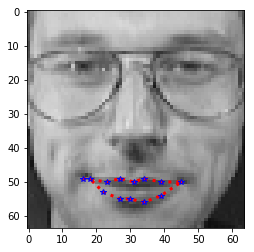

значение i = 271 мой =  0 дали =  1
mar= 0.23083635092296803
угол =  -0.06676560799818931


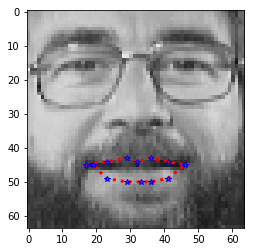

значение i = 273 мой =  0 дали =  1
mar= 0.1057939029253981
угол =  -0.07707515893586198


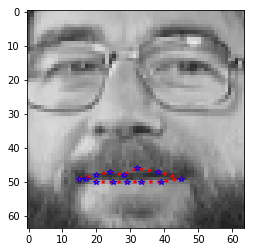

значение i = 274 мой =  0 дали =  1
mar= 0.15045937205113757
угол =  0.0


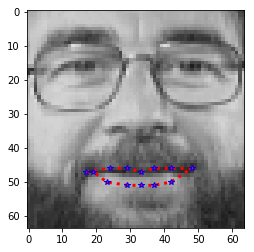

значение i = 276 мой =  0 дали =  1
mar= 0.20476528703246846
угол =  -0.06258150756627502


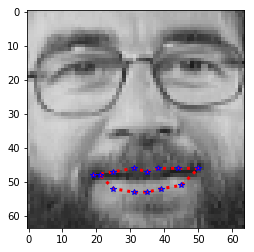

значение i = 303 мой =  0 дали =  1
mar= 0.3454008692082861
угол =  -0.13412911616973258


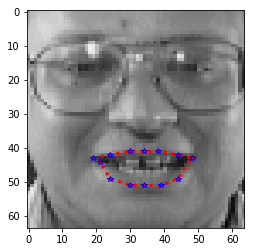

значение i = 354 мой =  0 дали =  1
mar= 0.22905485076995555
угол =  -0.32308624435174554


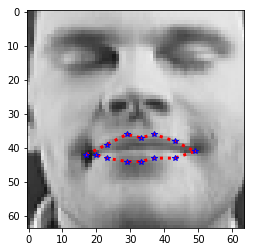

значение i = 363 мой =  0 дали =  1
mar= 0.1913394698580077
угол =  -0.14383695943619093


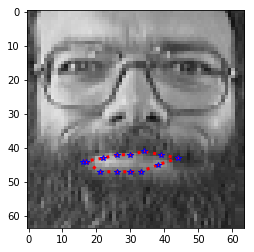

значение i = 364 мой =  0 дали =  1
mar= 0.20673754885671486
угол =  -0.12565513657513097


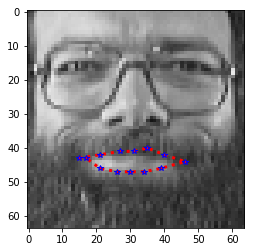

значение i = 368 мой =  0 дали =  1
mar= 0.17394270791975774
угол =  -0.14383695943619093


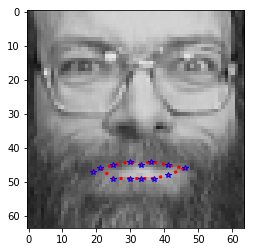

значение i = 369 мой =  0 дали =  1
mar= 0.21526447862129186
угол =  -0.25534192122103627


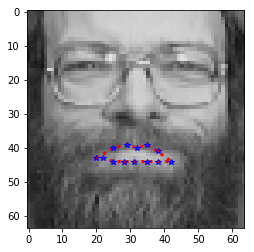

46


In [ ]:
copy = [1,25,28,29,40,41,42,43,46,48,49,60,61,62,65,69,70,72,74,75,77,84,86,96,112,120,121,125,164,168,174,187,188,190,191,204,206,207,208,211,212,214,216,217,219,222,228,229,
       234,235,237,240,241,242,244,246,249,255,263,265,279,288,300,302,307,310,311,312,314,316,322,323,324,325,326,327,328,340,348,349,350,361,367,380,381,382,385,388,391,392,393,395]
for i in copy:
    olivet_y2[i] = oli_y2[i]
    
compare(oln, olivet_y2, oli_y2)    

### Предобработка данных для второго датасета.

Нужно преоразовать данные разверности (400,64,64) в размерность (400,64,64,1)

In [ ]:
olitest = []
for i in range(oln.shape[0]):
    test_img = oln[i][:,:,np.newaxis]
    olitest.append(test_img)

olitest = np.array(olitest)

### Произведем тестовый запуск 2 даиасета для определения точности сети с текущими весами

(64, 64, 1)


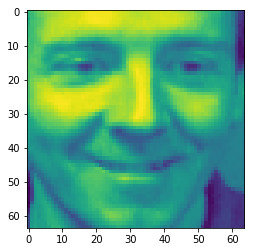

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


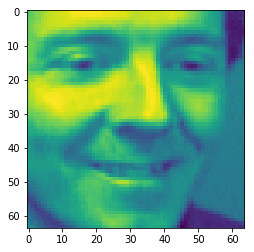

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


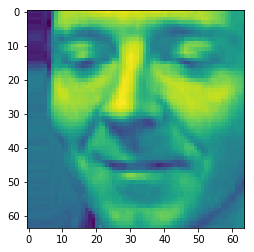

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


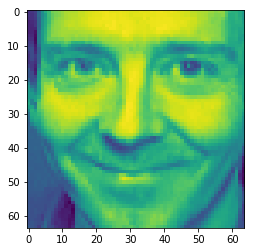

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


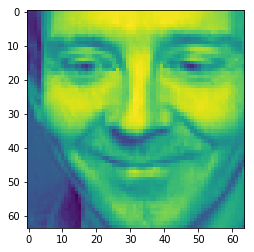

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


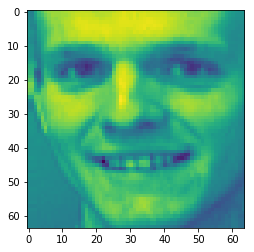

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


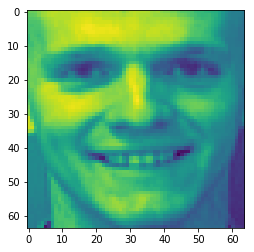

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


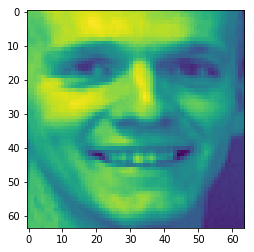

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


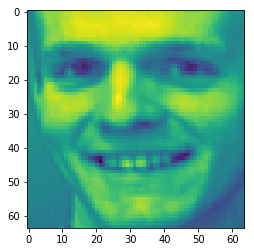

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


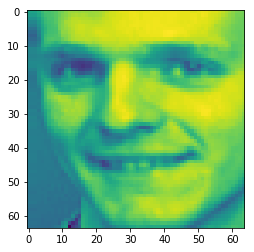

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


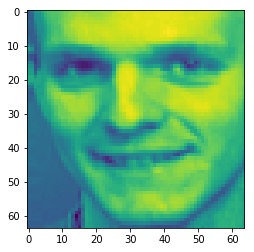

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


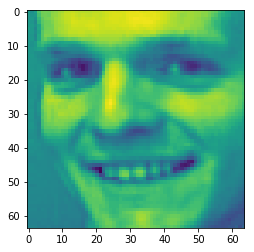

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


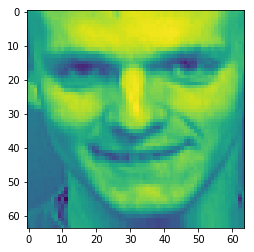

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


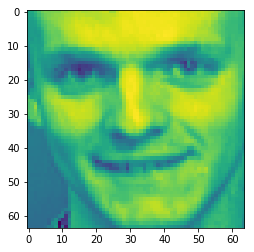

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


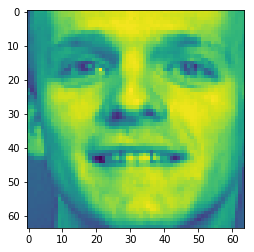

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


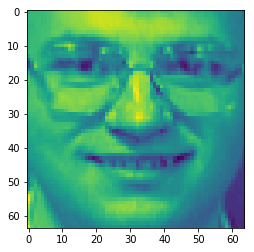

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


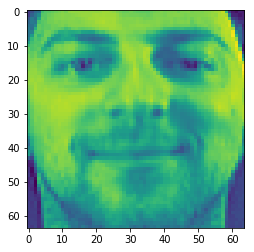

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


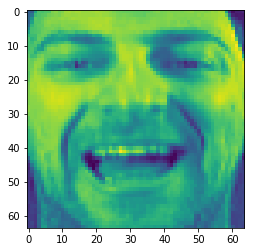

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


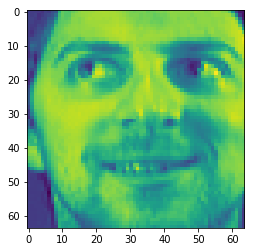

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


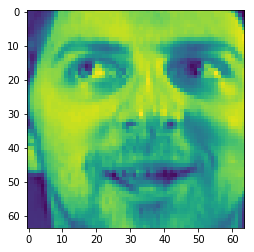

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


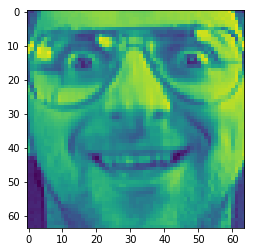

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


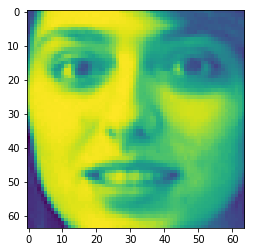

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


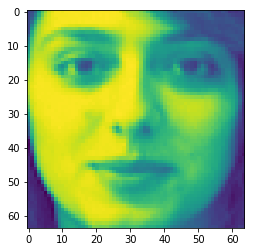

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


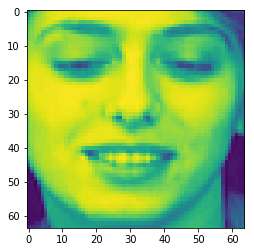

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


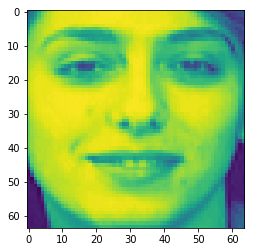

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


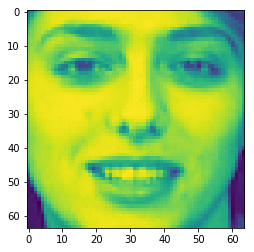

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


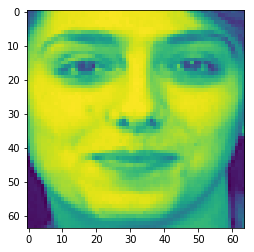

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


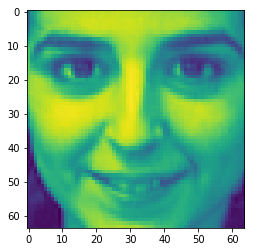

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


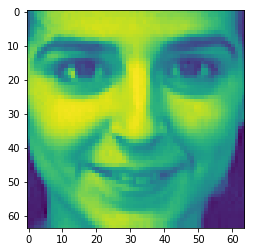

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


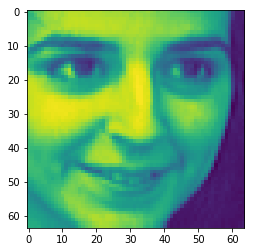

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


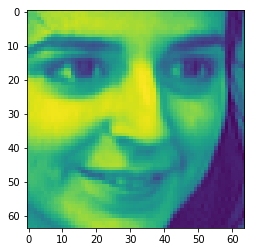

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


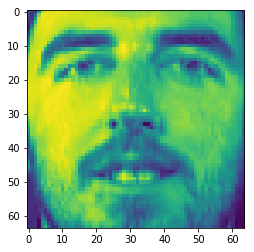

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


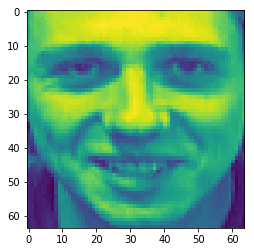

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


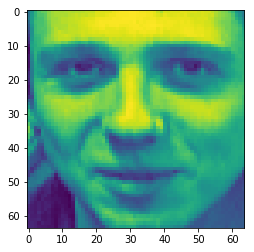

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


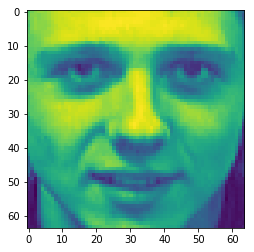

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


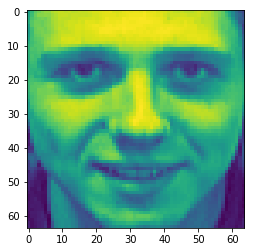

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


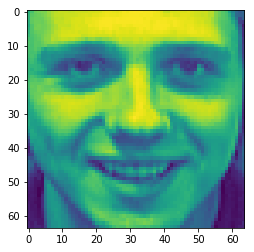

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


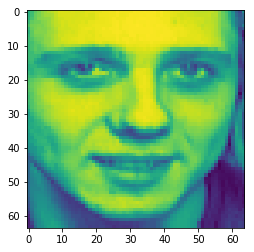

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


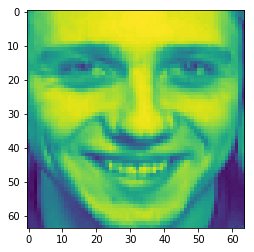

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


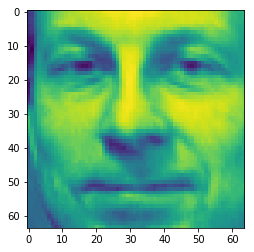

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


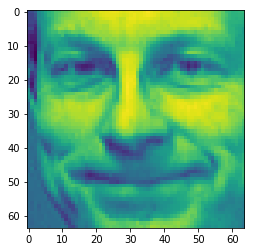

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


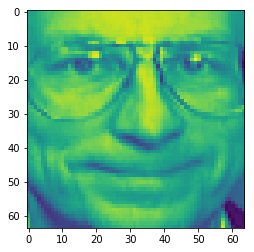

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


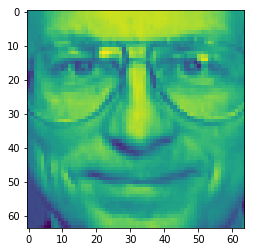

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


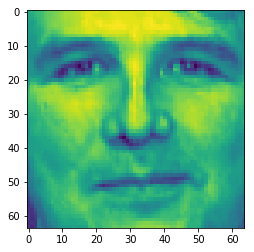

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


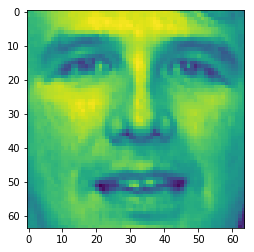

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


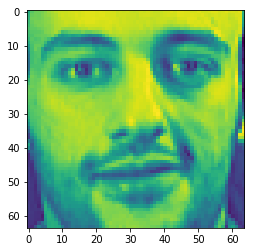

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


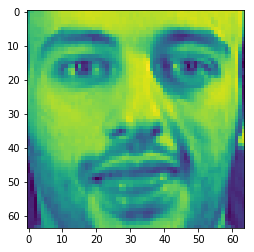

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


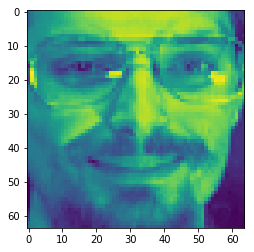

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


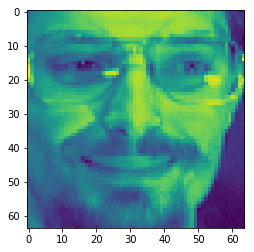

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


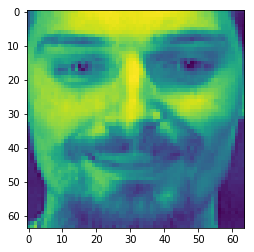

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


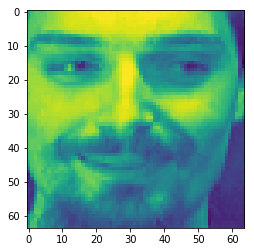

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


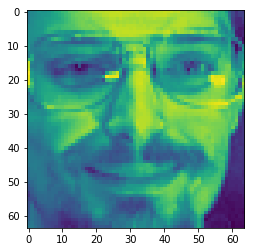

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


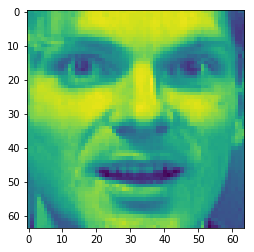

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


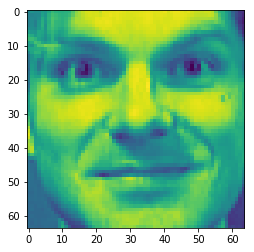

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


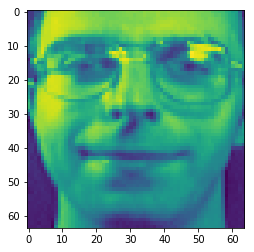

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


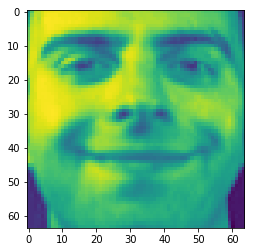

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


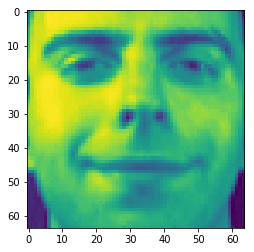

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


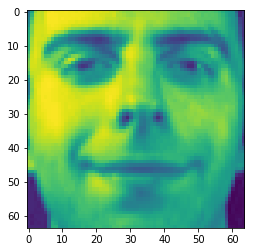

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


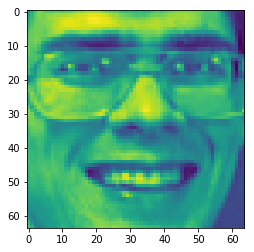

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


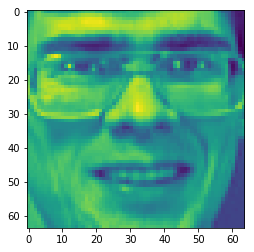

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


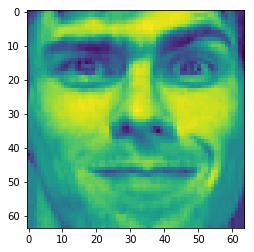

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


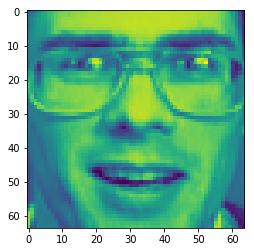

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


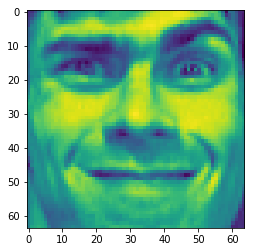

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


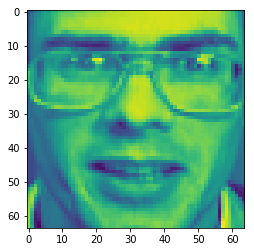

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


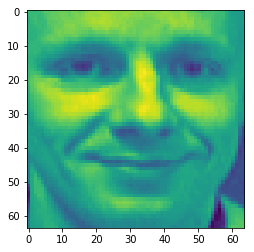

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


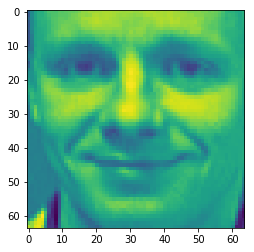

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


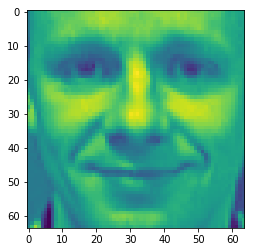

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


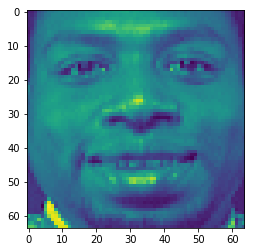

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


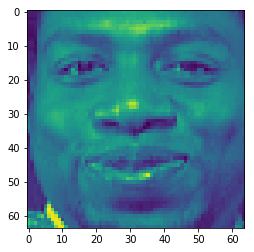

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


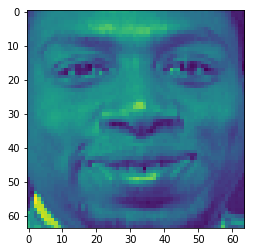

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


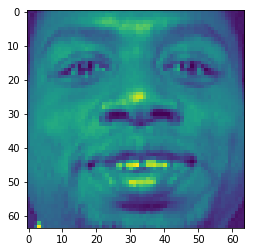

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


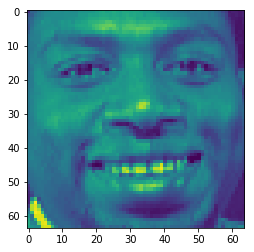

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


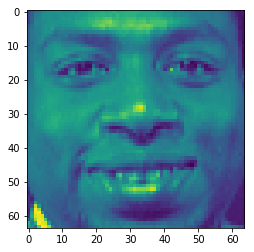

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


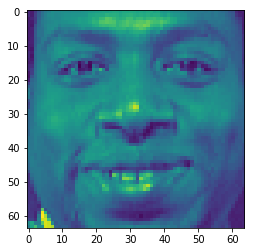

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


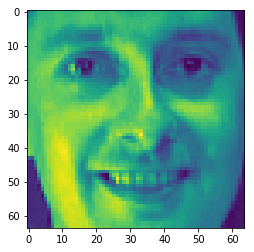

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


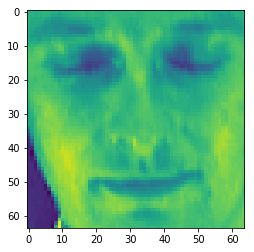

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


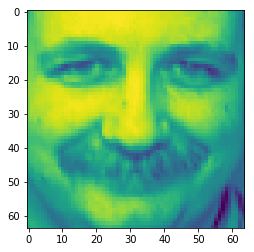

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


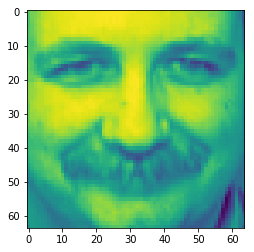

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


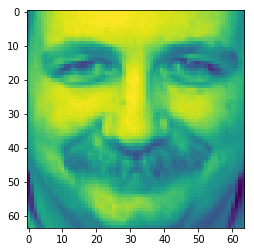

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


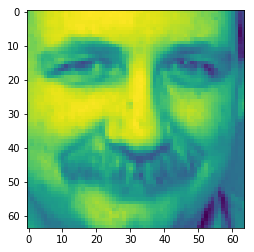

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


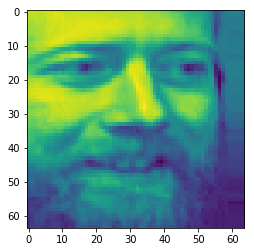

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


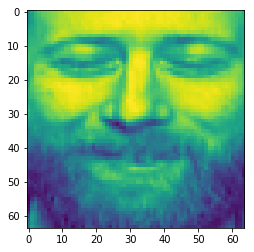

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


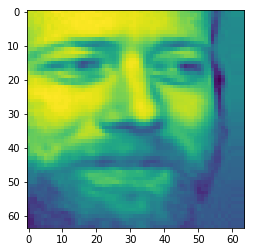

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


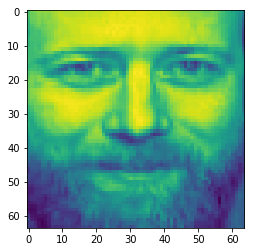

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


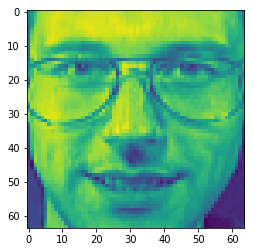

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


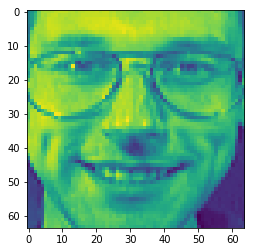

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


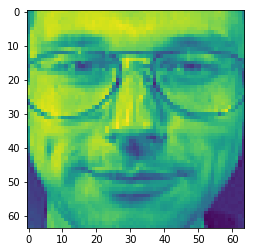

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


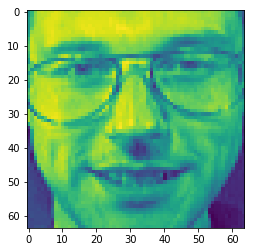

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


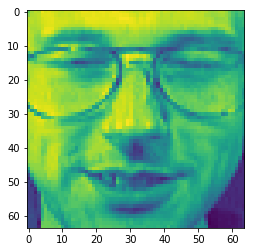

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


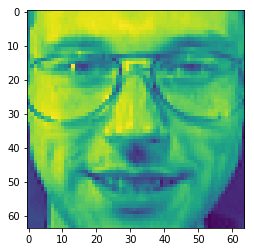

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


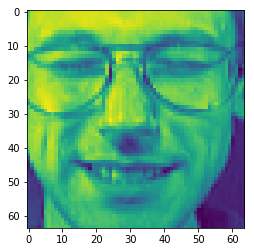

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


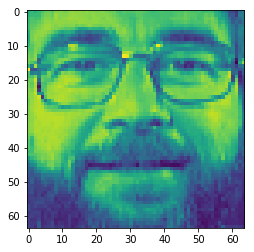

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


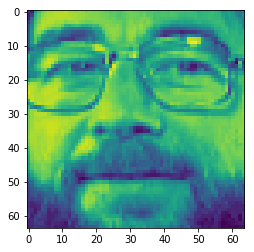

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


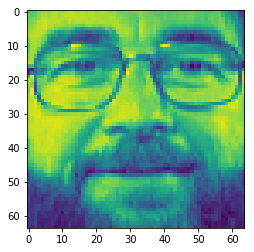

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


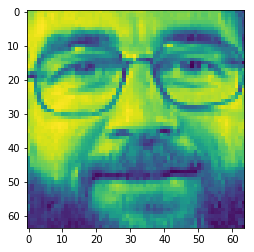

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


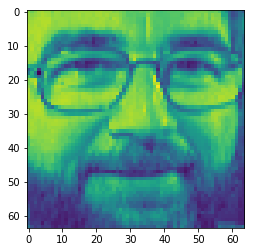

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


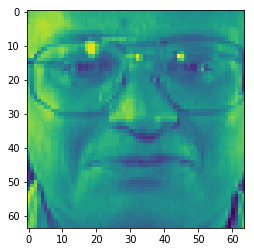

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


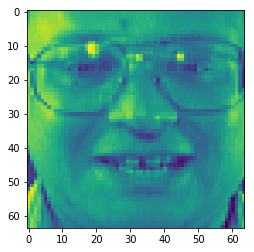

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


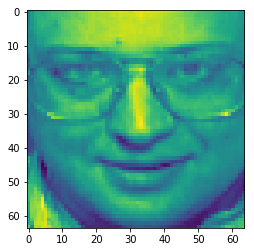

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


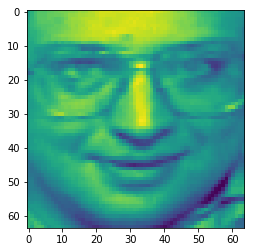

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


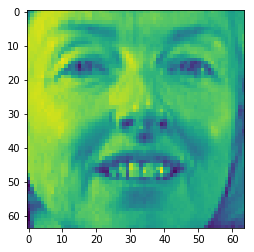

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


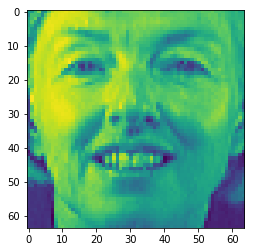

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


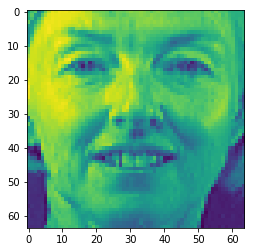

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


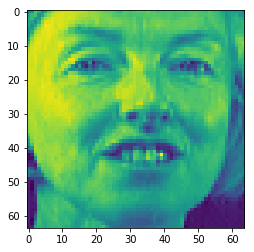

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


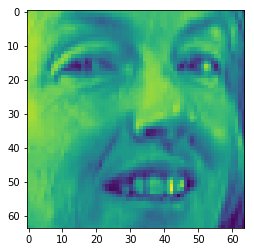

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


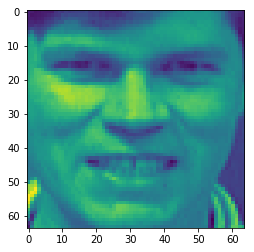

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


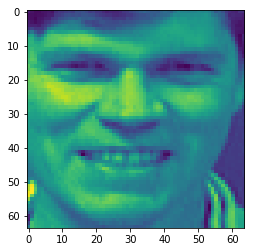

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


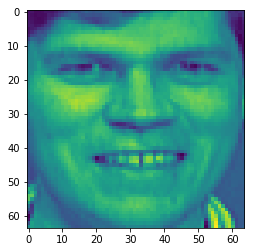

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


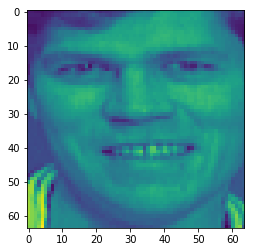

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


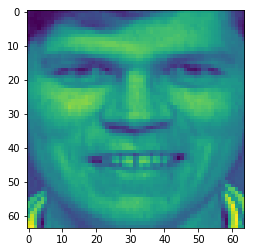

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


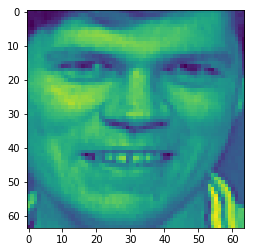

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


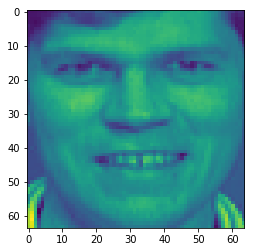

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


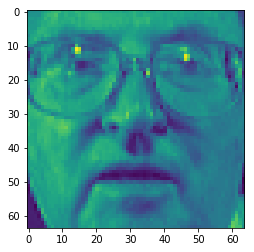

Проверочный класс =  0.0
Класс предсказаный =  1
(64, 64, 1)


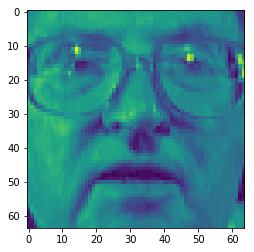

Проверочный класс =  0.0
Класс предсказаный =  1
(64, 64, 1)


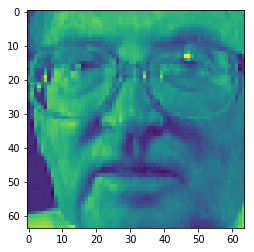

Проверочный класс =  0.0
Класс предсказаный =  1
(64, 64, 1)


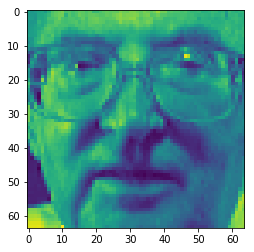

Проверочный класс =  0.0
Класс предсказаный =  1
(64, 64, 1)


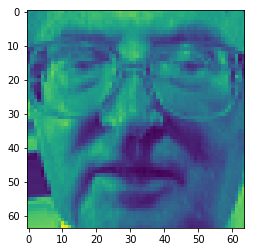

Проверочный класс =  0.0
Класс предсказаный =  1
(64, 64, 1)


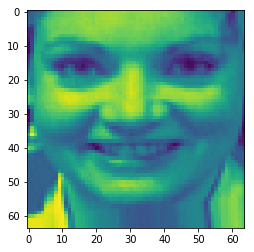

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


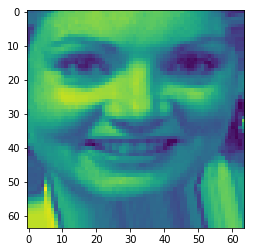

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


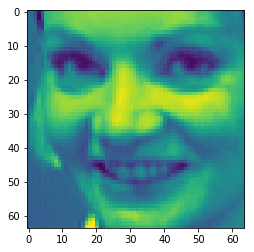

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


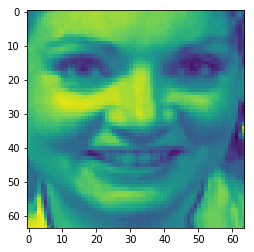

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


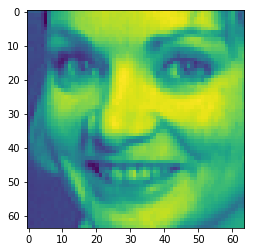

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


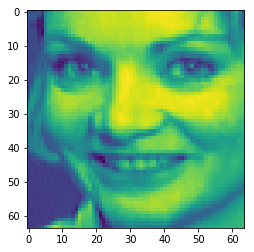

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


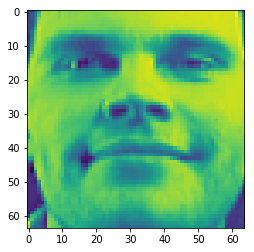

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


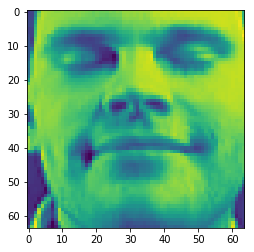

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


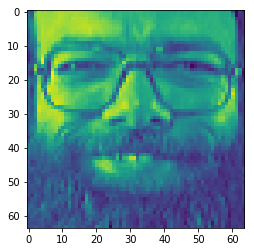

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


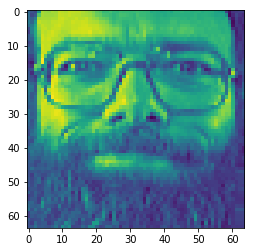

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


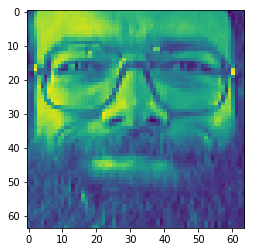

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


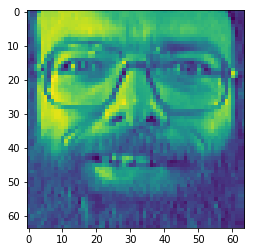

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


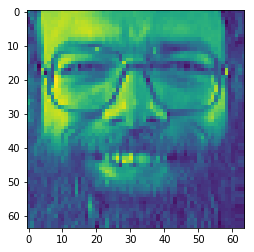

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


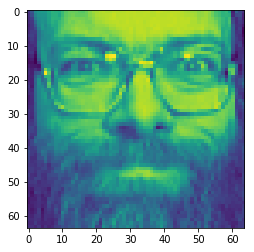

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


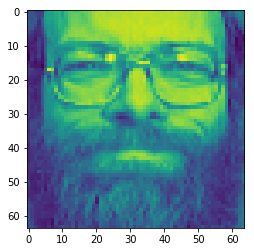

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


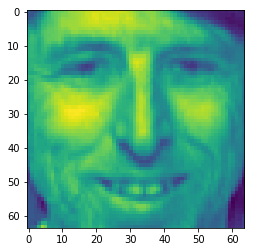

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


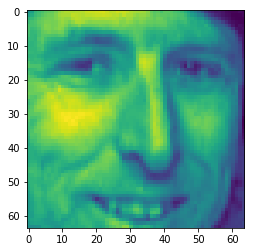

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


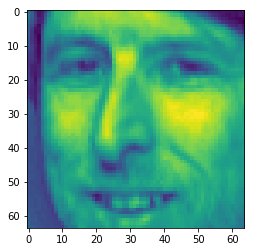

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


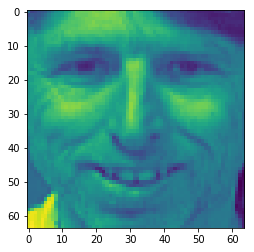

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


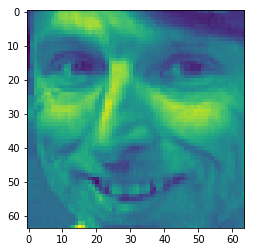

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


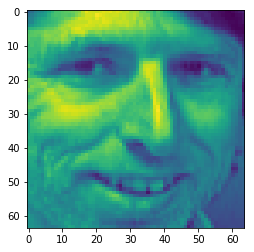

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


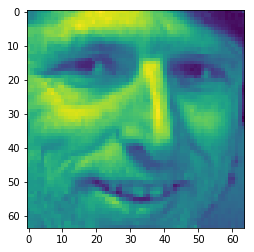

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


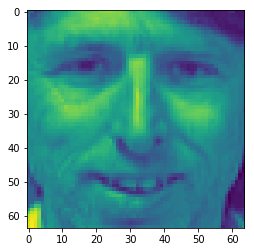

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


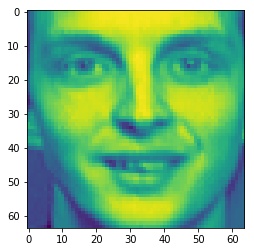

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


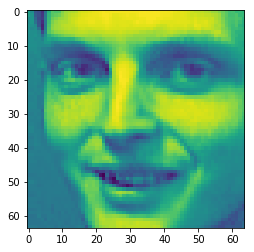

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


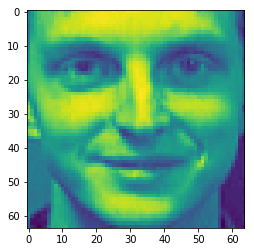

Проверочный класс =  1.0
Класс предсказаный =  0
(64, 64, 1)


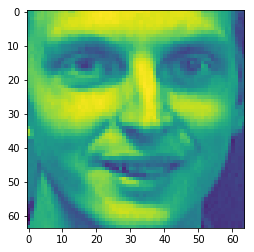

Проверочный класс =  1.0
Класс предсказаный =  0


In [ ]:
x_predict = model.predict(olitest)
for i in range(olitest.shape[0]):
    if x_predict[i] > 0.5:
        result = 1
    else:
        result = 0
        
    if oli_y2[i] != result:
        print(olitest[i][:,:].shape)
        plt.imshow(oln[i])
        plt.show()
        print('Проверочный класс = ', oli_y2[i])
        print('Класс предсказаный = ', result)

Запуск показал, что текущая архитектура сети может быть использована для работы со вторым датасетом, но ее нужно обучить на нем, чтобы сеть могла определять корректно улыбки 

#### Попытка дообучить сеть на втором датасете

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 1s 4ms/sample - loss: 0.6364 - acc: 0.6972 - val_loss: 0.6494 - val_acc: 0.6250
Epoch 2/5
360/360 [==============================] - 0s 818us/sample - loss: 0.5044 - acc: 0.7694 - val_loss: 0.6717 - val_acc: 0.6250
Epoch 3/5
360/360 [==============================] - 0s 799us/sample - loss: 0.3754 - acc: 0.8250 - val_loss: 0.7467 - val_acc: 0.6250
Epoch 4/5
360/360 [==============================] - 0s 815us/sample - loss: 0.3489 - acc: 0.8361 - val_loss: 0.7998 - val_acc: 0.6250
Epoch 5/5
360/360 [==============================] - 0s 801us/sample - loss: 0.3156 - acc: 0.8611 - val_loss: 0.8465 - val_acc: 0.6250
Epoch 00005: early stopping


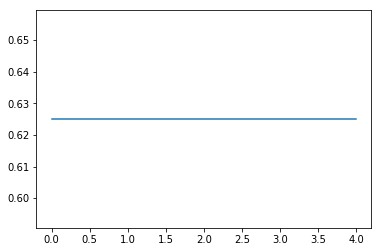

Максимум точности =  0.625


In [ ]:
epochs = 5
model = create_model()
history = model.fit(olitest, 
                    olivet_y2, 
                    batch_size=10, 
                    epochs=epochs,  
                    verbose=1, 
                    validation_split=0.1,
                   callbacks = callbacks)

plt.plot(history.history['val_acc'])
plt.show()
print("Максимум точности = ", max(history.history['val_acc']))

In [ ]:
x_predict = model.predict(olitest)
x=0
for i in range(olitest.shape[0]):
    if x_predict[i] > 0.5:
        result = 1
    else:
        result = 0
        
    if oli_y2[i] != result:
        x = x + 1
        #print(olitest[i][:,:].shape)
        #plt.imshow(oln[i])
        #plt.show()
        #print('Проверочный класс = ', oli_y2[i])
        #print('Класс предсказаный = ', result)
print(1-x/olitest.shape[0])       

0.65


In [ ]:
accuracy_nn = round(model.evaluate(x_test_dataset,y_test,verbose = 0)[1]*100)
print('Точность по тестовой выборке = :',accuracy_nn,'%')
print('Поищем эти картинки для контроля')
x_predict = model.predict(x_test_dataset)
x = 0 
for i in range(x_test_dataset.shape[0]):
    if x_predict[i] > 0.5:
        result = 1
    else:
        result = 0
        
    if y_test[i] != result:
        x = x + 1
print(1-x/x_test_dataset.shape[0])         

Точность по тестовой выборке = : 44.0 %
Поищем эти картинки для контроля
0.43999999999999995


***Результат проверки показал, что сеть очень плохо работает, если учится на двух разных датасетах по очереди. Общая точность очень сильно падает, для первого и медленно растет для второго***

## Произведем объеденение двух датасетов и разбивку на тестовую и тренировочную выборки.

In [ ]:
x_train2 = np.concatenate((x_train_dataset[0:400],olitest),axis = 0)
y_train2 = np.concatenate((y_train[0:400],olivet_y2),axis = 0)
from sklearn.model_selection import train_test_split 

x_train3, x_test3, y_train3, y_test3 = train_test_split(x_train2, y_train2, test_size=0.20, random_state=42)  
print(x_train3.shape, x_test3.shape, y_train3.shape, y_test3.shape)

(640, 64, 64, 1) (160, 64, 64, 1) (640,) (160,)


## Обучение сети на объединенном датасете.

Train on 576 samples, validate on 64 samples
Epoch 1/30
576/576 [==============================] - 2s 3ms/sample - loss: 0.6685 - acc: 0.6528 - val_loss: 0.6620 - val_acc: 0.5469
Epoch 2/30
576/576 [==============================] - 0s 818us/sample - loss: 0.5455 - acc: 0.6892 - val_loss: 0.5862 - val_acc: 0.6875
Epoch 3/30
576/576 [==============================] - 0s 789us/sample - loss: 0.4601 - acc: 0.7500 - val_loss: 0.4728 - val_acc: 0.7812
Epoch 4/30
576/576 [==============================] - 0s 825us/sample - loss: 0.4254 - acc: 0.7986 - val_loss: 0.4272 - val_acc: 0.7969
Epoch 5/30
576/576 [==============================] - 0s 790us/sample - loss: 0.4003 - acc: 0.7899 - val_loss: 0.4136 - val_acc: 0.7969
Epoch 6/30
576/576 [==============================] - 0s 814us/sample - loss: 0.3575 - acc: 0.8264 - val_loss: 0.4260 - val_acc: 0.7656
Epoch 7/30
576/576 [==============================] - 0s 794us/sample - loss: 0.3019 - acc: 0.8646 - val_loss: 0.4202 - val_acc: 0.8125
Epoch

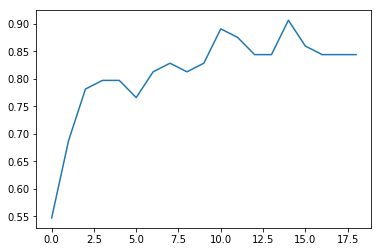

Максимум точности =  0.90625


In [ ]:
epochs = 30
model = create_model()
history = model.fit(x_train3, 
                    y_train3, 
                    batch_size=10, 
                    epochs=epochs,  
                    verbose=1, 
                    validation_split=0.1,
                   callbacks = callbacks)

plt.plot(history.history['val_acc'])
plt.show()
print("Максимум точности = ", max(history.history['val_acc']))

## Проверка сети на объединенном датасете после обучения.

In [ ]:
x_predict = model.predict(x_test3)
x=0
for i in range(x_test3.shape[0]):
    if x_predict[i] > 0.5:
        result = 1
    else:
        result = 0
        
    if y_test3[i] != result:
        x = x + 1
        #print(olitest[i][:,:].shape)
        #plt.imshow(oln[i])
        #plt.show()
        #print('Проверочный класс = ', oli_y2[i])
        #print('Класс предсказаный = ', result)
print(1-x/y_test3.shape[0]) 

0.875


Результат показан в 88,5% точности что превышает порог, указаный в курсовой в 75%.

# Тест на своих фото.

In [ ]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/Курс\ нейросетей/Курсовая/real2.zip './'



In [ ]:
z = zipfile.ZipFile('real2.zip', 'r')
z.extractall()


In [ ]:
import glob 
from tensorflow.keras.preprocessing import image

list_of_files = glob.glob('/content/real2/*.jpg')
dataset = []
for i in list_of_files:
    temp_file = image.load_img(i, target_size=(64, 64))
    temp_file = image.img_to_array(temp_file)
    dataset.append(temp_file[:, ::-1])
dataset = np.asarray(dataset)    
dataset = convertdataset(dataset)

(17, 64, 64, 1)


Запустим распознование и выведем результаты.


Картинка № 0


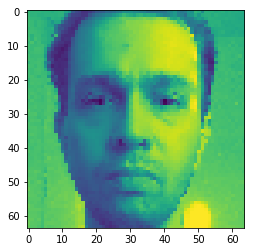

[[0.24070932]]

Картинка № 1


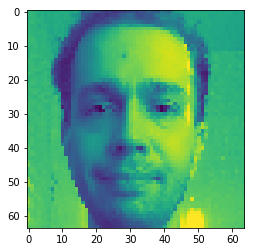

[[0.57824934]]

Картинка № 2


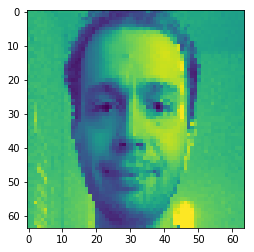

[[0.40288717]]

Картинка № 3


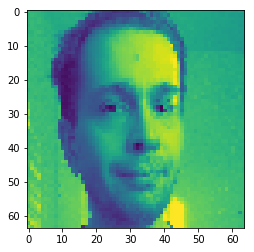

[[0.7954855]]

Картинка № 4


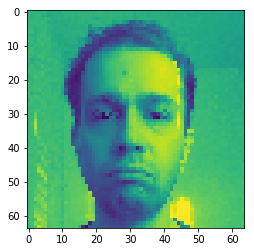

[[0.9466049]]

Картинка № 5


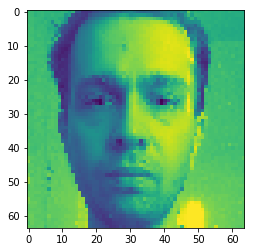

[[0.34502488]]

Картинка № 6


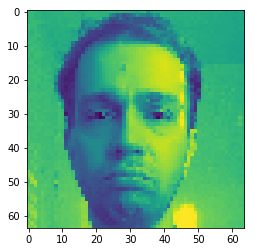

[[0.98757255]]

Картинка № 7


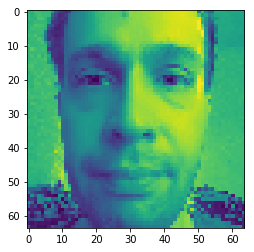

[[0.5096391]]

Картинка № 8


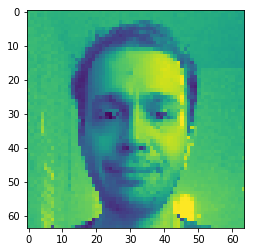

[[0.5721353]]

Картинка № 9


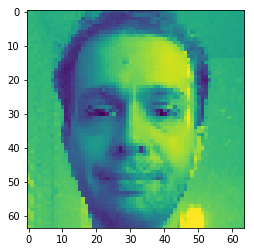

[[0.8744405]]

Картинка № 10


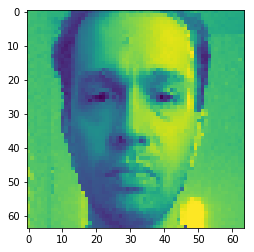

[[0.28891912]]

Картинка № 11


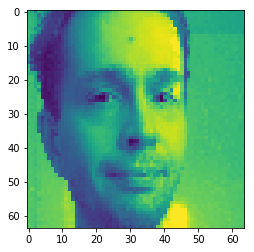

[[0.0270285]]

Картинка № 12


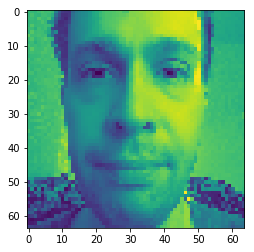

[[0.66153836]]

Картинка № 13


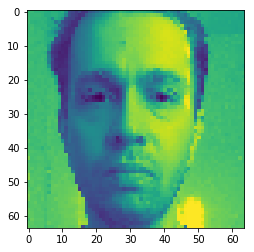

[[0.2031326]]

Картинка № 14


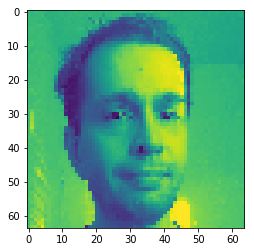

[[0.9731217]]

Картинка № 15


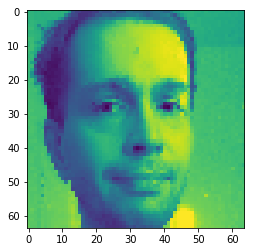

[[0.13791332]]

Картинка № 16


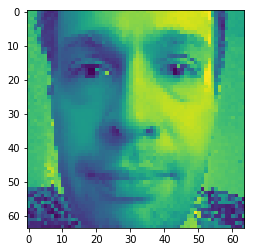

[[0.87883276]]


In [ ]:
for i in range(dataset.shape[0]):
    print('')
    print('Картинка №',i)
    plt.imshow(dataset[i][:,:,0])
    plt.show()
    print(model.predict(np.expand_dims(dataset[i],axis=0)))

# Отчет

В курсовой используются два совершенно разных датасета, как по объему так и по представлению данных. 

Поиск в интернете,  дал два варианта сети, которые могут подойти:
 - полносвязные
 - сверточные
 
Так как рекомендация была использовать, сверточные, то остановился на них. 
 
  
Для подбора оптимальной архитектуры описал ряд гипер параметров в виде списков. 

Создал генератор случайных архитектур для построения моделей.
Сгенерировал 30 моделей и запустил тестирование. 

После чего собрал все данные и вывел в таблицу ниже.

In [ ]:
df = pd.read_csv('datacalc.csv', delimiter=',')
df = df.drop(columns=['nan'])
df.index = df.acc_test
df = df.sort_index(ascending=False)
df.loc[df.index >= 0.966]

Unnamed: 0  layer1  kernel1  ...  dens3       acc  acc_test
acc_test                               ...                           
0.966667          15    20.0     20.0  ...    1.0  0.977778  0.966667
0.966667          28    30.0      9.0  ...    1.0  0.977778  0.966667
0.966667          27    10.0      7.0  ...    1.0  0.966667  0.966667
0.966667           5    30.0      5.0  ...    1.0  0.988889  0.966667
0.966667          24    30.0      9.0  ...    1.0  0.977778  0.966667
0.966667          20    10.0     15.0  ...    1.0  0.977778  0.966667
0.966667           8    15.0      7.0  ...    1.0  0.977778  0.966667
0.966667          19    15.0     11.0  ...    1.0  0.966667  0.966667
0.966667          18    10.0      5.0  ...    1.0  0.966667  0.966667
0.966667          11    15.0      5.0  ...    1.0  0.977778  0.966667
0.966667          17    10.0      7.0  ...    1.0  0.966667  0.966667
0.966667          16    30.0      9.0  ...    1.0  0.966667  0.966667

[12 rows x 13 columns]

Согласно этой таблицы собрал сеть с параметрами близкими к лучшим в таблице.
После ряда тестов, остановился на последней архитектуре.





In [ ]:
from keras.utils import plot_model

model2 = create_model()
plot_model(model2, to_file='model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1_120 ( (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 64, 64, 28)        11228     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 12, 12, 28)        0         
_________________________________________________________________
dropout_141 (Dropout)        (None, 12, 12, 28)        0         
_________________________________________________________________
batch_normalization_v1_121 ( (None, 12, 12, 28)        112       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 12, 12, 128)       89728     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 4, 4, 128)         0         
__________

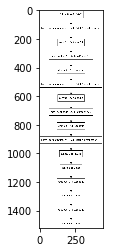

In [ ]:
plt.imshow(image.load_img('model.png'))

Основная проблема при работе над курсовой, это разметка второго датасета. 
Руками делать разметку не хотелось.

Задал вопросы куратору и по его рекомендации изучил библиотеку Dlib. 

Была проблема с определением координат, но ее успешно решил.

Использование коэффициента  "mar", для  определение улыбки показало, что это мало применимо, так как у разных людей форма рта, губ, мимики совершенно различны.

Пришлось написать свой метод. Он определяет углы наклона губ. 


Разметка датасета с использование моей функции успешно справилось с 67% картинок, остальные пришлось сверять с разметкой из группы.

После объединения датасетов и разбивки их на тренировочные и тестовые, обучил сеть с нуля. 

Окончательный вариант показал 88% точности на тестовой выборке, что превышало указаный в курсовой целевой показатель 75%.